<a href="https://colab.research.google.com/github/11doris/jazz-maestro/blob/colab_word_embeddings/chords_topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall -y gensim

Found existing installation: gensim 3.6.0
Uninstalling gensim-3.6.0:
  Successfully uninstalled gensim-3.6.0


In [2]:
pip install gensim

     |████████████████████████████████| 24.1 MB 2.3 kB/s 


In [3]:
pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 7.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 11.3 MB 213 kB/s 
     |████████████████████████████████| 15.7 MB 55 kB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=87b85676bbf120b2114bbcdd28afaabf5b85fa1e690237f06bddd48b0a3f363a
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into 

In [1]:
import gensim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pprint
import pandas as pd
import numpy as np

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
print(gensim.__version__)

4.1.2


# Initialization

## Download the Data

In [27]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1H8uRflGJGQecZlmy4jTK8aqKlyc-8C6y' -O input_seq.txt

--2021-11-03 13:27:40--  https://docs.google.com/uc?export=download&id=1H8uRflGJGQecZlmy4jTK8aqKlyc-8C6y
Resolving docs.google.com (docs.google.com)... 108.177.98.113, 108.177.98.138, 108.177.98.139, ...
Connecting to docs.google.com (docs.google.com)|108.177.98.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/flko4js5ijgek02fcp95sn8ihoepar16/1635946050000/14329102864480165501/*/1H8uRflGJGQecZlmy4jTK8aqKlyc-8C6y?e=download [following]
--2021-11-03 13:27:40--  https://doc-14-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/flko4js5ijgek02fcp95sn8ihoepar16/1635946050000/14329102864480165501/*/1H8uRflGJGQecZlmy4jTK8aqKlyc-8C6y?e=download
Resolving doc-14-4c-docs.googleusercontent.com (doc-14-4c-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-14-4c-docs.googleusercontent.com (doc-14-4c-d

Download the file with the meta data from Google Drive:

In [28]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Gy68KSn98UhfQm9YeRHjP6JsBzlN5z-S' -O input_meta.csv

--2021-11-03 13:27:42--  https://docs.google.com/uc?export=download&id=1Gy68KSn98UhfQm9YeRHjP6JsBzlN5z-S
Resolving docs.google.com (docs.google.com)... 74.125.20.102, 74.125.20.138, 74.125.20.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.20.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5pmqonfpoiag3j6pqct167qacd5m736n/1635946050000/14329102864480165501/*/1Gy68KSn98UhfQm9YeRHjP6JsBzlN5z-S?e=download [following]
--2021-11-03 13:27:43--  https://doc-0k-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5pmqonfpoiag3j6pqct167qacd5m736n/1635946050000/14329102864480165501/*/1Gy68KSn98UhfQm9YeRHjP6JsBzlN5z-S?e=download
Resolving doc-0k-4c-docs.googleusercontent.com (doc-0k-4c-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-0k-4c-docs.googleusercontent.com (doc-0k-4c-docs.

### Chords Data

In [29]:
path_to_file = '/content/input_seq.txt'

with open(path_to_file) as f: 
  lines = f.read().splitlines()

In [30]:
data = [line.split(' ') for line in lines]

### Meta Data

In [31]:
meta = pd.read_csv('input_meta.csv', sep='\t')
meta.head(5)

,id,file_name,title,composer,year,year_truncated,tonality,tune_key,tune_mode,structure,num_bars,time_signature,cycle_fifths_order,style,musicbrainz_id,wikidata_id,wikidata_allmusic,wiki_link,wikidata_description,lyricist
0,0,dataset/jazz1350/26-2.xml,26-2,John Coltrane,1960.0,1960.0,F major,F,major,AABA,32.0,4/4,-1.0,Medium Up Swing,eb51f0dd-c9a6-3849-b135-9cfaa7a90396,NaN,NaN,NaN,NaN,NaN
1,1,dataset/jazz1350/500 Miles High.xml,500 Miles High,Chick Corea,1978.0,1978.0,E minor,E,minor,NaN,26.0,4/4,1.0,Bossa Nova,1e03810a-6632-35ee-959b-dfd244be19b5,NaN,NaN,NaN,NaN,Neville Potter
2,2,dataset/jazz1350/502 Blues.xml,502 Blues,Jimmy Rowles,1962.0,1962.0,A minor,A,minor,NaN,32.0,3/4,0.0,Waltz,cff33fd3-7be2-3559-b06a-1d5cee201939,NaN,NaN,NaN,NaN,NaN
3,3,dataset/jazz1350/52nd Street Theme.xml,52nd Street Theme,Thelonious Monk,1944.0,1944.0,C major,C,major,AABA,32.0,4/4,0.0,Up Tempo Swing,aaa19faf-298a-3e89-9599-6a30866cd7fd,NaN,NaN,NaN,NaN,NaN
4,4,dataset/jazz1350/9.20 Special.xml,9.20 Special,Earle Warren,1941.0,1941.0,C major,C,major,AABA,32.0,4/4,0.0,Medium Swing,67755649-b89e-409c-ad6b-488f4cd455a5,Q16824165,NaN,https://en.wikipedia.org/wiki/9:20_Special,1941 song,William Engvick


In [32]:
titles = meta.loc[:, ['id', 'title']].drop_duplicates()
titles.set_index('id', inplace=True)
titles

,title
id,
0,26-2
1,500 Miles High
2,502 Blues
3,52nd Street Theme
4,9.20 Special
...,...
2041,You're Foolin' Someone
2042,You're Lucky To Me
2043,You're Nobody Till Somebody Loves You


In [35]:
assert len(data) == len(titles)

In [36]:
from gensim.test.utils import common_texts
import gensim.models as models
import gensim.corpora as corpora
from gensim.corpora.dictionary import Dictionary

# Create a corpus from a list of texts
id2word = corpora.Dictionary(data)

2021-11-03 13:28:06,538 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-11-03 13:28:06,616 : INFO : built Dictionary(154 unique tokens: ['AM7', 'Am7', 'B7', 'Bbm7', 'Bm7']...) from 2046 documents (total 93630 corpus positions)
2021-11-03 13:28:06,618 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(154 unique tokens: ['AM7', 'Am7', 'B7', 'Bbm7', 'Bm7']...) from 2046 documents (total 93630 corpus positions)", 'datetime': '2021-11-03T13:28:06.618223', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}


In [37]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data]

In [100]:
%%time
TOTAL_TOPICS = 10
lda_model = gensim.models.LdaModel(corpus=corpus, 
                                   id2word=id2word, 
                                   #chunksize=1740, 
                                   alpha='auto', 
                                   eta='auto', 
                                   random_state=42,
                                   iterations=500, 
                                   num_topics=TOTAL_TOPICS, 
                                   passes=20, 
                                   eval_every=None)

2021-11-03 14:15:05,871 : INFO : using autotuned alpha, starting with [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
2021-11-03 14:15:05,879 : INFO : using serial LDA version on this node
2021-11-03 14:15:05,882 : INFO : running online (multi-pass) LDA training, 10 topics, 20 passes over the supplied corpus of 2046 documents, updating model once every 2000 documents, evaluating perplexity every 0 documents, iterating 500x with a convergence threshold of 0.001000
2021-11-03 14:15:05,886 : INFO : PROGRESS: pass 0, at document #2000/2046
2021-11-03 14:15:08,644 : INFO : optimized alpha [0.05510038, 0.08093951, 0.059528105, 0.054837525, 0.06321943, 0.05217364, 0.08514071, 0.09186866, 0.06256696, 0.05617202]
2021-11-03 14:15:08,646 : INFO : merging changes from 2000 documents into a model of 2046 documents
2021-11-03 14:15:08,652 : INFO : topic #5 (0.052): 0.135*"Dm7" + 0.124*"C6" + 0.080*"Am6" + 0.068*"FM7" + 0.056*"E7" + 0.056*"BbM7" + 0.056*"G7(+b5)" + 0.043*"Am7" + 0.037*"Bb7" + 0.0

CPU times: user 19.9 s, sys: 484 ms, total: 20.4 s
Wall time: 20.4 s


In [57]:
# Train the model on the corpus.
# Build LDA model

#lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                           id2word=id2word,
#                                           num_topics=10, 
#                                           random_state=100,
#                                           #update_every=1,
#                                           #chunksize=10,
#                                           #passes=10,
#                                           alpha='symmetric',
#                                           #iterations=100,
#                                           per_word_topics=True)

2021-11-03 13:39:45,869 : INFO : using symmetric alpha at 0.1
2021-11-03 13:39:45,879 : INFO : using symmetric eta at 0.1
2021-11-03 13:39:45,883 : INFO : using serial LDA version on this node
2021-11-03 13:39:45,888 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 2046 documents, updating model once every 2000 documents, evaluating perplexity every 2046 documents, iterating 50x with a convergence threshold of 0.001000
2021-11-03 13:39:45,891 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2021-11-03 13:39:45,893 : INFO : PROGRESS: pass 0, at document #2000/2046
2021-11-03 13:39:47,128 : INFO : merging changes from 2000 documents into a model of 2046 documents
2021-11-03 13:39:47,134 : INFO : topic #9 (0.100): 0.167*"Am7" + 0.132*"E7" + 0.065*"Bm7b5" + 0.049*"FM7" + 0.049*"Dm7" + 0.048*"F7" + 0.032*"D7" + 0.028*"CM7" + 0.028*"C7" + 0.026*"A7"
2021-11-0

In [101]:
lda_model.print_topics()

2021-11-03 14:16:09,945 : INFO : topic #0 (0.062): 0.390*"Am" + 0.341*"E7" + 0.073*"Dm" + 0.034*"A7" + 0.033*"G7" + 0.032*"G#7" + 0.027*"B7" + 0.021*"D7" + 0.013*"G" + 0.008*"C"
2021-11-03 14:16:09,948 : INFO : topic #1 (0.083): 0.259*"C" + 0.166*"G7" + 0.158*"D7" + 0.122*"A7" + 0.087*"Dm" + 0.050*"G" + 0.029*"F" + 0.021*"Em" + 0.019*"C7" + 0.019*"Cdim"
2021-11-03 14:16:09,950 : INFO : topic #2 (0.038): 0.338*"Am7" + 0.175*"E7" + 0.097*"Bm7b5" + 0.048*"Dm7" + 0.046*"FM7" + 0.037*"Am6" + 0.036*"D7" + 0.028*"F#m7b5" + 0.022*"Bm7" + 0.021*"F7"
2021-11-03 14:16:09,951 : INFO : topic #3 (0.025): 0.106*"CM7" + 0.047*"Em7" + 0.046*"G#M7" + 0.040*"F#7" + 0.040*"Fm7" + 0.037*"Eb7" + 0.037*"C#7" + 0.036*"FM7" + 0.034*"BbM7" + 0.033*"C#M7"
2021-11-03 14:16:09,955 : INFO : topic #4 (0.150): 0.430*"C" + 0.263*"G7" + 0.118*"F" + 0.063*"C7" + 0.044*"D7" + 0.027*"Fm" + 0.016*"Ebdim" + 0.008*"A7" + 0.007*"G" + 0.007*"F#dim"
2021-11-03 14:16:09,959 : INFO : topic #5 (0.027): 0.626*"C6" + 0.120*"Dm7" + 0

[(0,
  '0.390*"Am" + 0.341*"E7" + 0.073*"Dm" + 0.034*"A7" + 0.033*"G7" + 0.032*"G#7" + 0.027*"B7" + 0.021*"D7" + 0.013*"G" + 0.008*"C"'),
 (1,
  '0.259*"C" + 0.166*"G7" + 0.158*"D7" + 0.122*"A7" + 0.087*"Dm" + 0.050*"G" + 0.029*"F" + 0.021*"Em" + 0.019*"C7" + 0.019*"Cdim"'),
 (2,
  '0.338*"Am7" + 0.175*"E7" + 0.097*"Bm7b5" + 0.048*"Dm7" + 0.046*"FM7" + 0.037*"Am6" + 0.036*"D7" + 0.028*"F#m7b5" + 0.022*"Bm7" + 0.021*"F7"'),
 (3,
  '0.106*"CM7" + 0.047*"Em7" + 0.046*"G#M7" + 0.040*"F#7" + 0.040*"Fm7" + 0.037*"Eb7" + 0.037*"C#7" + 0.036*"FM7" + 0.034*"BbM7" + 0.033*"C#M7"'),
 (4,
  '0.430*"C" + 0.263*"G7" + 0.118*"F" + 0.063*"C7" + 0.044*"D7" + 0.027*"Fm" + 0.016*"Ebdim" + 0.008*"A7" + 0.007*"G" + 0.007*"F#dim"'),
 (5,
  '0.626*"C6" + 0.120*"Dm7" + 0.115*"G7" + 0.107*"D7" + 0.015*"Cdim7" + 0.004*"E7" + 0.003*"A7" + 0.002*"G7(+b5)" + 0.001*"FM7" + 0.000*"Bb7"'),
 (6,
  '0.277*"F7" + 0.198*"C7" + 0.081*"Bb7" + 0.066*"G7" + 0.045*"Gm7" + 0.039*"Eb7" + 0.036*"G#7" + 0.030*"Cm7" + 0.023*"C#7" 

In [102]:
import random

def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(200, 22%%, %d%%)" % random.randint(30, 70)

In [103]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(#stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  #max_words=10,
                  colormap='tab10',
                  color_func=grey_color_func,
                  #color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(num_topics=10, num_words=50, formatted=False)
len(topics)

10

In [104]:
lda_model[corpus]

Source: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

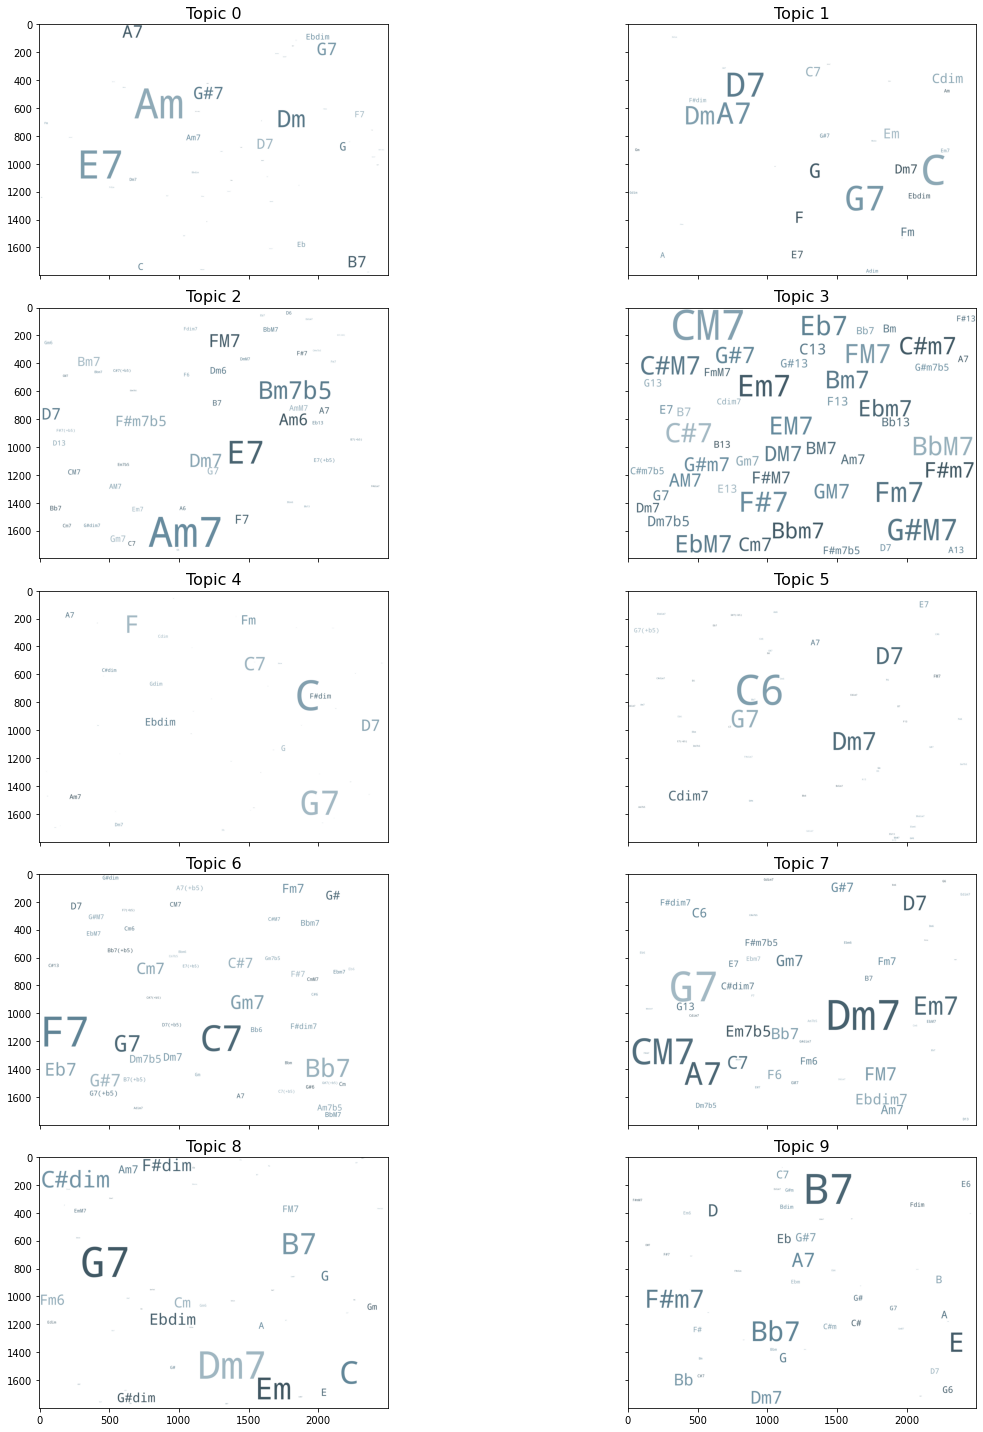

In [105]:
fig, axes = plt.subplots(5, 2, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    #plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
#plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [106]:
from collections import Counter
topics = lda_model.show_topics(num_topics=15, num_words=10, formatted=False)
data_flat = [w for w_list in data for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

out

[['Am', 0, 0.389889, 1868],
 ['E7', 0, 0.34067616, 3510],
 ['Dm', 0, 0.07305616, 755],
 ['A7', 0, 0.03360732, 4870],
 ['G7', 0, 0.03313636, 13133],
 ['G#7', 0, 0.03189033, 1001],
 ['B7', 0, 0.02716224, 1461],
 ['D7', 0, 0.021455653, 4755],
 ['G', 0, 0.013468975, 944],
 ['C', 0, 0.00820217, 9739],
 ['C', 1, 0.25858822, 9739],
 ['G7', 1, 0.16563165, 13133],
 ['D7', 1, 0.1584019, 4755],
 ['A7', 1, 0.121632494, 4870],
 ['Dm', 1, 0.08720401, 755],
 ['G', 1, 0.04955296, 944],
 ['F', 1, 0.028729223, 2489],
 ['Em', 1, 0.020888368, 403],
 ['C7', 1, 0.019284904, 3768],
 ['Cdim', 1, 0.018719098, 200],
 ['Am7', 2, 0.3379594, 3853],
 ['E7', 2, 0.17546551, 3510],
 ['Bm7b5', 2, 0.097125284, 934],
 ['Dm7', 2, 0.04791513, 7341],
 ['FM7', 2, 0.04572987, 1792],
 ['Am6', 2, 0.03708364, 356],
 ['D7', 2, 0.035822216, 4755],
 ['F#m7b5', 2, 0.028232044, 556],
 ['Bm7', 2, 0.021867817, 454],
 ['F7', 2, 0.02084697, 1808],
 ['CM7', 3, 0.106436744, 5144],
 ['Em7', 3, 0.046786375, 2400],
 ['G#M7', 3, 0.046092022, 4

In [107]:
df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

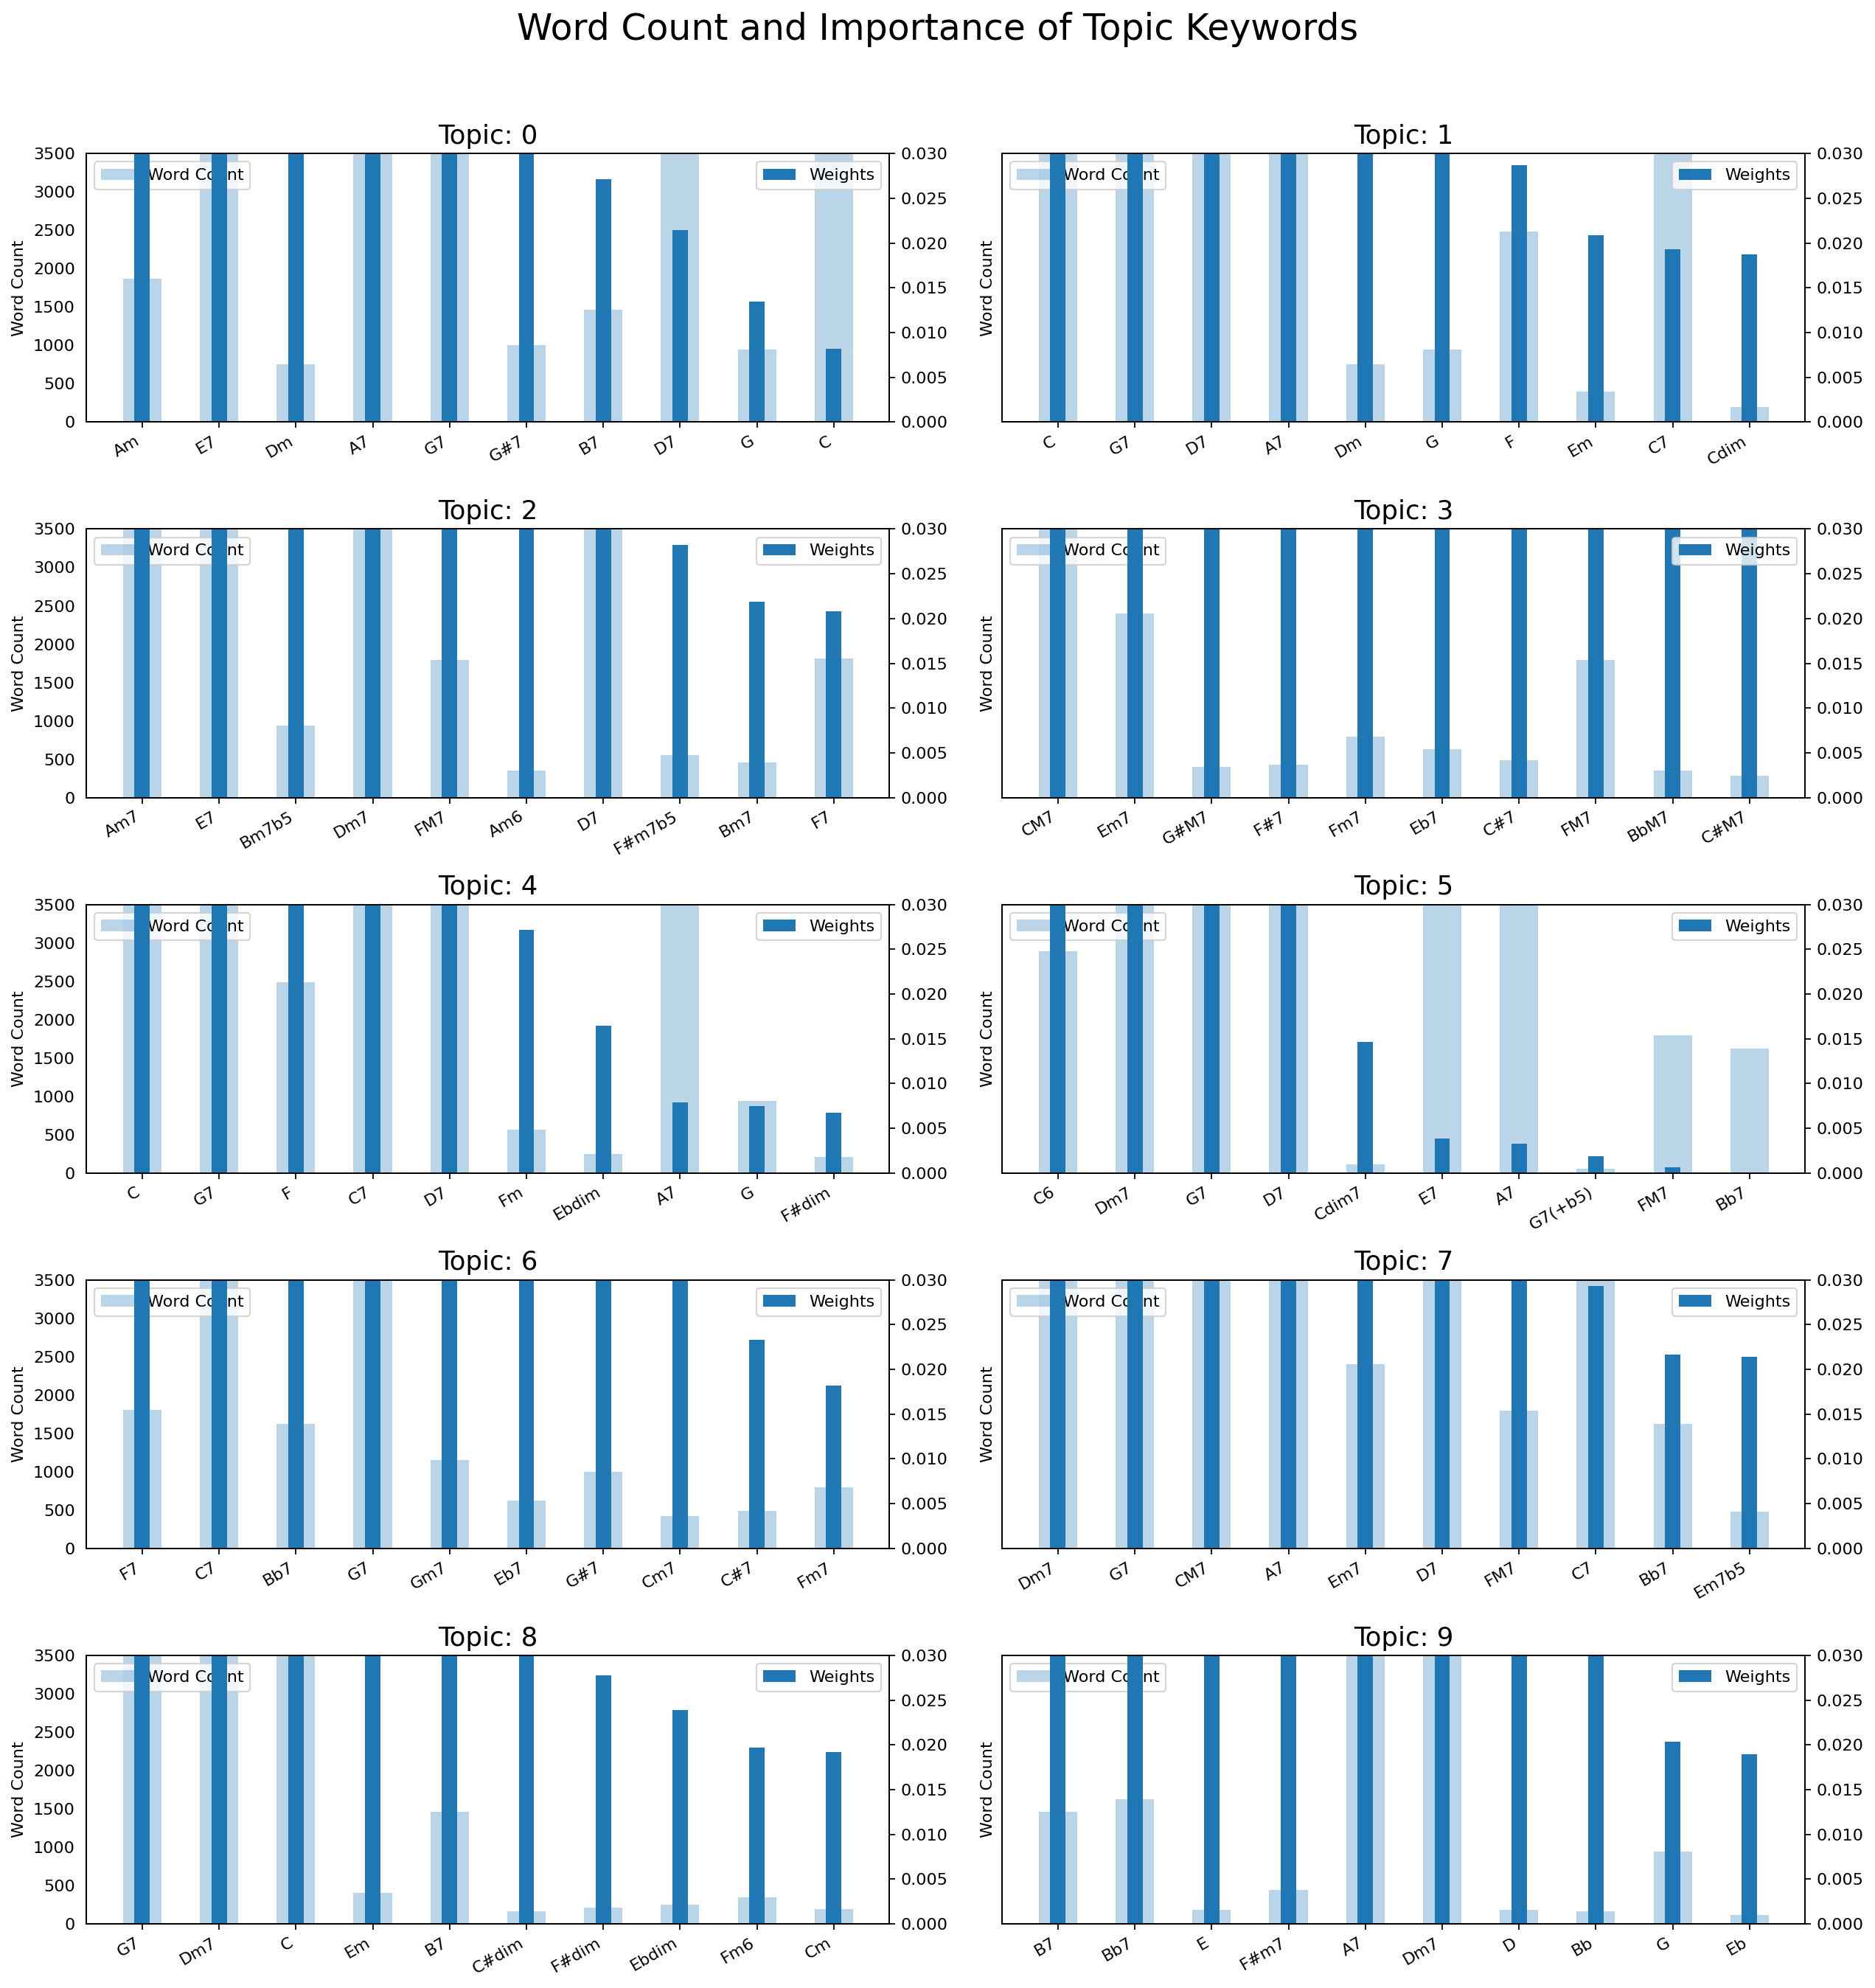

In [108]:
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(16,16), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", 
           data=df.loc[df.topic_id==i, :], 
           #color=cols[i], 
           width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], 
                #color=cols[i], 
                width=0.2, label='Weights')
    ax.set_ylabel('Word Count')
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [109]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

ValueError: ignored

In [110]:
df_dominant_topic_in_each_doc

,Dominant_Topic,count
0,0,28
1,1,352
2,2,55
3,3,656
4,4,167
5,5,508
6,6,5
7,7,17
8,8,49
9,9,208


In [111]:
topic_top3words

[(0, 'G'),
 (0, 'D7'),
 (0, 'C'),
 (1, 'G7'),
 (1, 'Dm7'),
 (1, 'C6'),
 (2, 'Am'),
 (2, 'E7'),
 (2, 'C'),
 (3, 'C'),
 (3, 'G7'),
 (3, 'F'),
 (4, 'Dm7'),
 (4, 'A7'),
 (4, 'C7'),
 (5, 'Dm7'),
 (5, 'G7'),
 (5, 'CM7'),
 (6, 'CM7'),
 (6, 'D7'),
 (6, 'Dm7'),
 (7, 'A7'),
 (7, 'E7'),
 (7, 'Dm7'),
 (8, 'F7'),
 (8, 'B7'),
 (8, 'G7'),
 (9, 'Am7'),
 (9, 'E7'),
 (9, 'Bm7b5')]

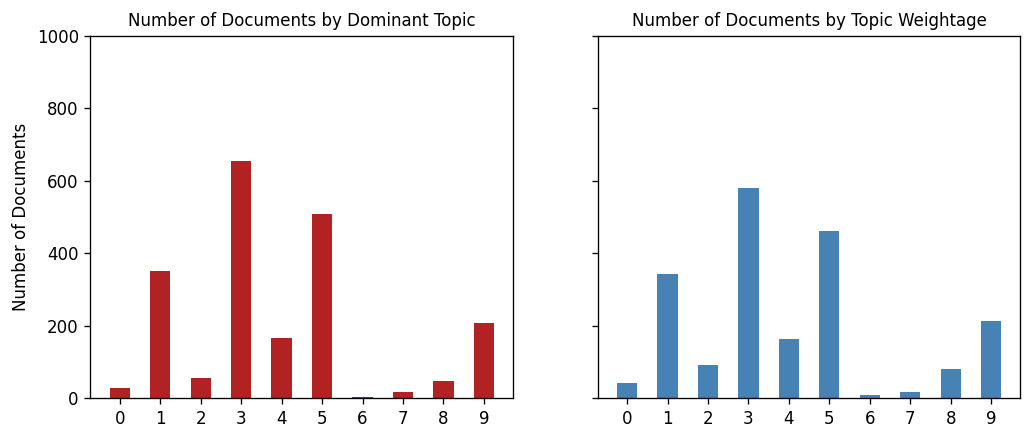

In [112]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
#ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
#ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [113]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 10
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

TypeError: ignored

In [114]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.033989 -0.101178       1        1  31.677569
4     -0.283896 -0.048448       2        1  17.477060
1     -0.245693  0.054809       3        1  10.414151
2      0.188052  0.190081       4        1  10.086940
3      0.324773 -0.106075       5        1   8.547514
6      0.160953 -0.158185       6        1   7.265478
0      0.031224  0.361500       7        1   4.489547
5     -0.116804 -0.071314       8        1   4.201548
9      0.104527 -0.053671       9        1   3.174766
8     -0.197126 -0.067519      10        1   2.665427, topic_info=   Term         Freq        Total Category  logprob  loglift
30    C  9898.000000  9898.000000  Default  30.0000  30.0000
34   C6  2905.000000  2905.000000  Default  29.0000  29.0000
9   Dm7  7541.000000  7541.000000  Default  28.0000  28.0000
1   Am7  3857.000000  3857.000000  Default  27.0000  27.0000
10   E7  3457.000000  3457.000000  Default  26.0000  26.0000
..  ...          ...          ...      ...      ...      ...
18   A7     0.070059  4865.936727  Topic10 -10.4807  -7.5236
6    C7     0.066731  3521.273404  Topic10 -10.5294  -7.2489
60   Fm     0.066511   598.518843  Topic10 -10.5327  -5.4800
33  Bb7     0.066477  1606.480331  Topic10 -10.5332  -6.4679
26  Em7     0.066439  2378.081160  Topic10 -10.5338  -6.8607

[458 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
102       3  0.475741      A
102       5  0.008495      A
102       9  0.348311      A
102      10  0.161412      A
75        5  0.966760    A13
...     ...       ...    ...
54        1  0.080162  Gm7b5
54        5  0.400810  Gm7b5
54        6  0.480972  Gm7b5
139       6  0.714918   GmM7
139       9  0.238306   GmM7

[396 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 2, 3, 4, 7, 1, 6, 10, 9])

## Evaluating Topic Model Quality


In [115]:
cv_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=corpus, 
                                                      texts=data,
                                                      dictionary=id2word, 
                                                      coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda.get_coherence()

umass_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=corpus, 
                                                         texts=data,
                                                         dictionary=id2word, 
                                                         coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda.get_coherence()

perplexity = lda_model.log_perplexity(corpus)

print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

2021-11-03 14:17:10,103 : INFO : using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2021-11-03 14:17:10,204 : INFO : WordOccurrenceAccumulator accumulated stats from 1000 documents
2021-11-03 14:17:10,289 : INFO : WordOccurrenceAccumulator accumulated stats from 2000 documents
2021-11-03 14:17:10,734 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2021-11-03 14:17:10,749 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2021-11-03 14:17:11,769 : INFO : -3.104 per-word bound, 8.6 perplexity estimate based on a held-out corpus of 2046 documents with 93630 words


Avg. Coherence Score (Cv): 0.5072484366131891
Avg. Coherence Score (UMass): -2.6396937248369183
Model Perplexity: -3.1043811780356907


with 15 topics

Avg. Coherence Score (Cv): 0.4431952139279488

Avg. Coherence Score (UMass): -1.7311264568500886

Model Perplexity: -3.2576540394272673



### Dominant Topics in Tunes

In [116]:
tm_results = lda_model[corpus] 

In [117]:
for topics in tm_results[:5]:
  print(topics)

[(2, 0.041853618), (3, 0.49900565), (6, 0.15785594), (7, 0.21607111), (9, 0.07917971)]
[(2, 0.26423472), (3, 0.616656), (7, 0.10329878)]
[(2, 0.5164078), (3, 0.46975723)]
[(2, 0.19294302), (4, 0.53767955), (7, 0.26385933)]
[(4, 0.031215679), (6, 0.44584572), (7, 0.33990893), (9, 0.17805731)]


In [118]:
topics = [[(term, round(wt, 3)) 
               for term, wt in lda_model.show_topic(n, topn=20)] 
                   for n in range(0, lda_model.num_topics)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['Am', 'E7', 'Dm', 'A7', 'G7', 'G#7', 'B7', 'D7', 'G', 'C', 'F7', 'Am7', 'Ebdim', 'Eb', 'Dm7', 'Fm', 'Bbdim', 'Fdim', 'F', 'Ddim']

Topic #2:
['C', 'G7', 'D7', 'A7', 'Dm', 'G', 'F', 'Em', 'C7', 'Cdim', 'Dm7', 'Fm', 'E7', 'A', 'Ebdim', 'F#dim', 'G#7', 'Adim', 'Em7', 'Am']

Topic #3:
['Am7', 'E7', 'Bm7b5', 'Dm7', 'FM7', 'Am6', 'D7', 'F#m7b5', 'Bm7', 'F7', 'G7', 'Dm6', 'A7', 'Gm7', 'AmM7', 'B7', 'D13', 'CM7', 'AM7', 'Em7']

Topic #4:
['CM7', 'Em7', 'G#M7', 'F#7', 'Fm7', 'Eb7', 'C#7', 'FM7', 'BbM7', 'C#M7', 'EM7', 'Bm7', 'EbM7', 'C#m7', 'Ebm7', 'G#7', 'Bbm7', 'F#m7', 'DM7', 'GM7']

Topic #5:
['C', 'G7', 'F', 'C7', 'D7', 'Fm', 'Ebdim', 'A7', 'G', 'F#dim', 'Am7', 'Gdim', 'C#dim', 'Dm7', 'Cdim', 'Eb', 'Edim', 'Dm', 'Em', 'Adim']

Topic #6:
['C6', 'Dm7', 'G7', 'D7', 'Cdim7', 'E7', 'A7', 'G7(+b5)', 'FM7', 'Bb7', 'Am7', 'C7', 'Bdim7', 'Bbdim7', 'G#7(+b5)', 'Dm7b5', 'C#6', 'Gdim7', 'F#dim7', 'F6']

Topic #7:
['F7', 'C7', 'Bb7', 'G7', 'Gm7', 'Eb7', 'G#7', 'Cm7', 'C#7', 'Fm7', 'G#', 'Dm7b

In [119]:
len(topics)

10

In [141]:
topics_df = pd.DataFrame([[term for term, wt in topic] 
                              for topic in topics], 
                         columns = ['Term'+str(i) for i in range(1, 21)],
                         index=['Topic '+str(t) for t in range(1, lda_model.num_topics+1)]).T
topics_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
Term1,Am,C,Am7,CM7,C,C6,F7,Dm7,G7,B7
Term2,E7,G7,E7,Em7,G7,Dm7,C7,G7,Dm7,Bb7
Term3,Dm,D7,Bm7b5,G#M7,F,G7,Bb7,CM7,C,E
Term4,A7,A7,Dm7,F#7,C7,D7,G7,A7,Em,F#m7
Term5,G7,Dm,FM7,Fm7,D7,Cdim7,Gm7,Em7,B7,A7
Term6,G#7,G,Am6,Eb7,Fm,E7,Eb7,D7,C#dim,Dm7
Term7,B7,F,D7,C#7,Ebdim,A7,G#7,FM7,F#dim,D
Term8,D7,Em,F#m7b5,FM7,A7,G7(+b5),Cm7,C7,Ebdim,Bb
Term9,G,C7,Bm7,BbM7,G,FM7,C#7,Bb7,Fm6,G
Term10,C,Cdim,F7,C#M7,F#dim,Bb7,Fm7,Em7b5,Cm,Eb


In [142]:
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic])  
                              for topic in topics],
                         columns = ['TermsPerTopic'],
                         index=['Topic'+str(t) for t in range(1, lda_model.num_topics+1)]
                         )
topics_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,TermsPerTopic
Topic1,"Am, E7, Dm, A7, G7, G#7, B7, D7, G, C, F7, Am7, Ebdim, Eb, Dm7, Fm, Bbdim, Fdim, F, Ddim"
Topic2,"C, G7, D7, A7, Dm, G, F, Em, C7, Cdim, Dm7, Fm, E7, A, Ebdim, F#dim, G#7, Adim, Em7, Am"
Topic3,"Am7, E7, Bm7b5, Dm7, FM7, Am6, D7, F#m7b5, Bm7, F7, G7, Dm6, A7, Gm7, AmM7, B7, D13, CM7, AM7, Em7"
Topic4,"CM7, Em7, G#M7, F#7, Fm7, Eb7, C#7, FM7, BbM7, C#M7, EM7, Bm7, EbM7, C#m7, Ebm7, G#7, Bbm7, F#m7, DM7, GM7"
Topic5,"C, G7, F, C7, D7, Fm, Ebdim, A7, G, F#dim, Am7, Gdim, C#dim, Dm7, Cdim, Eb, Edim, Dm, Em, Adim"
Topic6,"C6, Dm7, G7, D7, Cdim7, E7, A7, G7(+b5), FM7, Bb7, Am7, C7, Bdim7, Bbdim7, G#7(+b5), Dm7b5, C#6, Gdim7, F#dim7, F6"
Topic7,"F7, C7, Bb7, G7, Gm7, Eb7, G#7, Cm7, C#7, Fm7, G#, Dm7b5, Dm7, D7, Am7b5, F#7, Bbm7, F#dim7, G7(+b5), A7"
Topic8,"Dm7, G7, CM7, A7, Em7, D7, FM7, C7, Bb7, Em7b5, Gm7, Ebdim7, C6, G#7, Am7, F6, Fm7, G13, Fm6, C#dim7"
Topic9,"G7, Dm7, C, Em, B7, C#dim, F#dim, Ebdim, Fm6, Cm, G, G#dim, Am7, E, A, FM7, Gm, EmM7, G#, Gm6"
Topic10,"B7, Bb7, E, F#m7, A7, Dm7, D, Bb, G, Eb, G#7, C7, A, B, G6, C#, E6, G#, F#, D7"


In [143]:
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]
corpus_topics[:10]
#corpus_topics = topics

[(3, 0.4990062),
 (3, 0.61665887),
 (2, 0.5164098),
 (4, 0.537679),
 (6, 0.44587675),
 (3, 0.44401124),
 (7, 0.8798164),
 (7, 0.4436071),
 (7, 0.74334526),
 (2, 0.34700966)]

In [144]:
corpus_topic_df = pd.DataFrame()
corpus_topic_df['Document'] = range(0, len(data))
corpus_topic_df['DominantTopic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution%'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['TopicDesc'] = [topics_df.iloc[t[0]]['TermsPerTopic'] for t in corpus_topics]
corpus_topic_df['Tunes'] = data

In [145]:
corpus_topic_df['Title'] = titles['title']

In [146]:
corpus_topic_df

,Document,DominantTopic,Contribution%,TopicDesc,Tunes,Title
0,0,4,49.90,"CM7, Em7, G#M7, F#7, Fm7, Eb7, C#7, FM7, BbM7, C#M7, EM7, Bm7, EbM7, C#m7, Ebm7, G#7, Bbm7, F#m7, DM7, GM7","[CM7, Eb7, G#M7, B7, EM7, G7, Gm7, C7, FM7, G#7, C#M7, E7, Am7, D7, Dm7, G7, CM7, Eb7, G#M7, B7, EM7, G7, Gm7, C7, FM7, Eb7, G#M7, B7, EM7, G7, CM7, Gm7, C7, Bm7, E7, AM7, C7, FM7, Bbm7, Eb7, G#M7, Dm7, G7, CM7, Eb7, G#M7, B7, EM7, G7, Gm7, C7, FM7, Eb7, G#M7, B7, EM7, G7, CM7]",26-2
1,1,4,61.67,"CM7, Em7, G#M7, F#7, Fm7, Eb7, C#7, FM7, BbM7, C#M7, EM7, Bm7, EbM7, C#m7, Ebm7, G#7, Bbm7, F#m7, DM7, GM7","[Am7, Am7, Cm7, Cm7, EbM7, EbM7, Em7b5, A7, Dm7, Dm7, Bm7b5, Bm7b5, Bbm7, Bbm7, Fm7, Fm7, E7, E7, Fm7, Fm7, C#M7, C#M7, Fm7, Fm7, C#M7, C#M7]",500 Miles High
2,2,3,51.64,"Am7, E7, Bm7b5, Dm7, FM7, Am6, D7, F#m7b5, Bm7, F7, G7, Dm6, A7, Gm7, AmM7, B7, D13, CM7, AM7, Em7","[Am7, C#M7, Bm7b5, E7, Am7, C#M7, Bm7b5, E7, Cm7, F7, BbM7, G#m7, C#7, F#m7b5, B7, EM7, EM7, E7, Am7, C#M7, Bm7b5, E7, Am7, C#M7, Bm7b5, E7, Cm7, F7, BbM7, G#m7, C#7, F#m7b5, B7, Em7, Em7]",502 Blues
3,3,5,53.77,"C, G7, F, C7, D7, Fm, Ebdim, A7, G, F#dim, Am7, Gdim, C#dim, Dm7, Cdim, Eb, Edim, Dm, Em, Adim","[C, Am7, Dm7, G7, C, Am7, Dm7, G7, C, Am7, Dm7, G7, C, G7, C, C, Am7, Dm7, G7, C, Am7, Dm7, G7, C, Am7, Dm7, G7, C, G7, C, C7, C7, F6, F6, D7, D7, G7, G7, C, Am7, Dm7, G7, C, Am7, Dm7, G7, C, Am7, Dm7, G7, C, G7, C]",52nd Street Theme
4,4,7,44.59,"F7, C7, Bb7, G7, Gm7, Eb7, G#7, Cm7, C#7, Fm7, G#, Dm7b5, Dm7, D7, Am7b5, F#7, Bbm7, F#dim7, G7(+b5), A7","[C7, Ebm6, C7, Ebm6, Bb, Bb7, A7, G#7, G7, C7, F#dim7, C7, G#7, G7, C7, Ebm6, C7, Ebm6, Bb, Bb7, A7, G#7, G7, C7, F#dim7, C7, F7, Bb, Bb, Eb, Eb6, Eb6, Eb6, G7, F, F6, F7, F7, C7, Ebm6, C7, Ebm6, Bb, Bb7, A7, G#7, G7, C7, F#dim7, C6, F7, Bb, D7]",9.20 Special
...,...,...,...,...,...,...
2041,2041,9,66.34,"G7, Dm7, C, Em, B7, C#dim, F#dim, Ebdim, Fm6, Cm, G, G#dim, Am7, E, A, FM7, Gm, EmM7, G#, Gm6","[C, C, C#dim, G7, G7, G7, G7, C, C#dim, G7, Dm7, G7, C, C, C#dim, G7, G7, G7, G7, C, Dm7, C, E, F, FM7, F#dim, C, C, B7, B7, Em, B7, Dm7, G7, C, C, C#dim, G7, G7, G7, G7, C, Ebdim, G7, Dm7, G7]",You're Foolin' Someone
2042,2042,8,73.09,"Dm7, G7, CM7, A7, Em7, D7, FM7, C7, Bb7, Em7b5, Gm7, Ebdim7, C6, G#7, Am7, F6, Fm7, G13, Fm6, C#dim7","[Dm7, G7, Em7b5, A7, Dm7, G#7, G7, C, C, Dm7, G7, Em7b5, A7, Dm7, G#7, G7, C, C, A7, A7, A7, A7, Dm7, G7, D7, G7, Dm7, G7, Em7b5, A7, Dm7, G#7, G7, C, C]",You're Lucky To Me
2043,2043,2,70.94,"C, G7, D7, A7, Dm, G, F, Em, C7, Cdim, Dm7, Fm, E7, A, Ebdim, F#dim, G#7, Adim, Em7, Am","[C, E7, A7, A7, Dm, G7, C, Em7, C, G7, Em7, Cdim, Dm7, Dm7, Dm7, D7, Dm7, G7, Dm7, G7, C, E7, A7, A7, Dm, A7, Dm, A7, Dm, F, Cdim, C, E7, Dm, D7, G7, C, C]",You're Nobody Till Somebody Loves You
2044,2044,5,67.42,"C, G7, F, C7, D7, Fm, Ebdim, A7, G, F#dim, Am7, Gdim, C#dim, Dm7, Cdim, Eb, Edim, Dm, Em, Adim","[G7, G7, C, C, G7, G7, C, F, G#, C, C, G7, G7, C, F, C, C, G7, C, G7, F7, F7, F7, C, F7, F7, C, C, F7, F7, F7, C, F7, F7, C, F, C]",Your Feet's Too Big


In [148]:
corpus_topic_df.groupby('DominantTopic').apply(lambda topic_set: (topic_set.sort_values(by=['Contribution%'], 
                                                                                         ascending=False)
                                                                             .iloc[0])
)


,Document,DominantTopic,Contribution%,TopicDesc,Tunes,Title
DominantTopic,,,,,,
1,1880,1,99.28,"Am, E7, Dm, A7, G7, G#7, B7, D7, G, C, F7, Am7, Ebdim, Eb, Dm7, Fm, Bbdim, Fdim, F, Ddim","[G, Am, Am, G, Am, Am, G, Am, Am, G, Am, Am, Am, E7, E7, Am, E7, E7, E7, Am, Am, E7, Am, Am, G, Am, Am, G, Am, Am, G, Am, Am, G, Am, Am, Am, E7, E7, Am, E7, E7, E7, Am, Am, E7, Am, Am, A7, A7, Dm, Dm, E7, E7, Am, Am, Am, Am, Am, Am, Dm, Dm, Am, Am, E7, E7, Am, Am]","Shout 'Em, Aunt Tillie"
2,1346,2,99.31,"C, G7, D7, A7, Dm, G, F, Em, C7, Cdim, Dm7, Fm, E7, A, Ebdim, F#dim, G#7, Adim, Em7, Am","[C, G#7, C, G#7, C, A7, Dm, A7, Dm, Dm, A7, Dm, Dm, A7, Dm, D7, D7, G7, G7, C, G#7, C, G#7, C, A7, Dm, A7, Dm, D7, D7, D7, D7, D7, D7, G7, G7, C, C7, F, D7, G7, G7, C, G7, C, C7, F, D7, G7, G7, C, C, D7, D7, D7, D7, D7, D7, G7, G7, C, C7, F, D7, G7, G7, C, C]",Ace In The Hole
3,50,3,99.23,"Am7, E7, Bm7b5, Dm7, FM7, Am6, D7, F#m7b5, Bm7, F7, G7, Dm6, A7, Gm7, AmM7, B7, D13, CM7, AM7, Em7","[Am7, Am7, F#m7b5, FM7, Am7, F#m7b5, Bm7b5, E7, Am7, Am7, F#m7b5, FM7, Am7, F#m7b5, Bm7b5, E7, Am7, Am7, Am7, F#m7b5, FM7, Am7, F#m7b5, Bm7b5, E7, Am7, Am7, F#m7b5, FM7, Am7, F#m7b5, Bm7b5, E7, Am7, Am7, G7, F7, E7, Am7, G7, F7, E7, Am7, G7, F7, E7, Am7, G7, F7, E7, Am7, Am7, F#m7b5, FM7, Am7, F#m7b5, Bm7b5, E7, Am7, Am7, F#m7b5, FM7, Am7, F#m7b5, Bm7b5, E7, Am7]",Alfie's Theme
4,1248,4,99.06,"CM7, Em7, G#M7, F#7, Fm7, Eb7, C#7, FM7, BbM7, C#M7, EM7, Bm7, EbM7, C#m7, Ebm7, G#7, Bbm7, F#m7, DM7, GM7","[CM7, BbM7, G#M7, F#M7, FM7, B13, EM7, AM7, EbM7, G#M7, C#M7, F#M7, BM7, EM7, AM7, DM7, CM7, BbM7, G#M7, F#M7, FM7, B13, EM7, AM7, EbM7, G#M7, C#M7, F#M7, BM7, EM7, AM7, DM7, G#7, G#7, G#7, G#7, G7, G7, G7, G7, CM7, BbM7, G#M7, F#M7, FM7, B13, EM7, AM7, EbM7, G#M7, C#M7, F#M7, BM7, EM7, AM7, DM7]",Walkin' up
5,2021,5,99.77,"C, G7, F, C7, D7, Fm, Ebdim, A7, G, F#dim, Am7, Gdim, C#dim, Dm7, Cdim, Eb, Edim, Dm, Em, Adim","[C, Ebdim, G7, C, Ebdim, G7, C, Am7, D7, G7, C, Ebdim, G7, C, Ebdim, G7, C, C7, F, Fm, C, G7, C, C, Ebdim, G7, C, Ebdim, G7, C, Am7, D7, G7, C, Ebdim, G7, C, Ebdim, G7, C, C7, F, Fm, C, G7, C, G7, G7, C, C, G7, G7, C, C, G7, G7, C, C, F, Fm, C, A7, D7, G7, C, C, Ebdim, G7, C, Ebdim, G7, C, Am7, D7, G7, C, Ebdim, G7, C, Ebdim, G7, C, C7, F, Fm, C, G7, C, G7, G7, G7, Gdim, G7, C, C#dim, G7, G7, C, C#dim, G7, ...]",Wolverine Blues
6,767,6,83.61,"C6, Dm7, G7, D7, Cdim7, E7, A7, G7(+b5), FM7, Bb7, Am7, C7, Bdim7, Bbdim7, G#7(+b5), Dm7b5, C#6, Gdim7, F#dim7, F6","[C6, C6, Dm7, Dm7, G7, G7, C6, C6, Am7, Am7, Dm7, Dm7, Dm7, Dm7, G7, C6, C6]",Mack The Knife
7,144,7,99.29,"F7, C7, Bb7, G7, Gm7, Eb7, G#7, Cm7, C#7, Fm7, G#, Dm7b5, Dm7, D7, Am7b5, F#7, Bbm7, F#dim7, G7(+b5), A7","[C7, C#7, C7, C#7, C7, C#7, C7, C#7, F7, F7, C7, C#7, C7, A7(+b5), Dm7, G7, C7, C#7, C7, C#7, C7, C#7, C7, C#7, C7, C#7, C7, C#7, F7, F7, C7, C#7, C7, A7(+b5), Dm7, G7, C7, C#7, C7, F#7, Fm7, Cm7, D7, G7(+b5), CM7, Ebm7, G#7, C#M7, Ebm7, G#7, Dm7, G7, C7, C#7, C7, C#7, C7, C#7, C7, C#7, F7, F7, C7, C#7, C7, A7(+b5), Dm7, G7, C7, C#7, C7, C#7]",Black Coffee
8,703,8,99.26,"Dm7, G7, CM7, A7, Em7, D7, FM7, C7, Bb7, Em7b5, Gm7, Ebdim7, C6, G#7, Am7, F6, Fm7, G13, Fm6, C#dim7","[CM7, Ebdim7, Dm7, G13, CM7, Ebdim7, Dm7, G13, Gm7, C7, FM7, Fm6, Em7, Am7, G#7, G7, CM7, Ebdim7, Dm7, G13, CM7, Ebdim7, Dm7, G13, Gm7, C7, FM7, Fm6, Dm7, G7, C6, F#m7b5, B7, Em7, A7, Dm7, G7, G7, F#m7b5, B7, Em7, A7, Dm7, G7, G7, CM7, Ebdim7, Dm7, G13, CM7, Ebdim7, Dm7, G7, Gm7, C7, FM7, Fm6, CM7, Dm7, E7, A7, Dm7, G7, C6, G7]",Let's Call The Whole Thing Off
9,2041,9,66.34,"G7, Dm7, C, Em, B7, C#dim, F#dim, Ebdim, Fm6, Cm, G, G#dim, Am7, E, A, FM7, Gm, EmM7, G#, Gm6","[C, C, C#dim, G7, G7, G7, G7, C, C#dim, G7, Dm7, G7, C, C, C#dim, G7, G7, G7, G7, C, Dm7, C, E, F, FM7, F#dim, C, C, B7, B7, Em, B7, Dm7, G7, C, C, C#dim, G7, G7, G7, G7, C, Ebdim, G7, Dm7, G7]",You're Foolin' Someone


### List the Tunes of the individual Topics

In [155]:
corpus_topic_df.query("DominantTopic == 1").sort_values('Contribution%', ascending=False).head(20)

,Document,DominantTopic,Contribution%,TopicDesc,Tunes,Title
1880,1880,1,99.28,"Am, E7, Dm, A7, G7, G#7, B7, D7, G, C, F7, Am7, Ebdim, Eb, Dm7, Fm, Bbdim, Fdim, F, Ddim","[G, Am, Am, G, Am, Am, G, Am, Am, G, Am, Am, Am, E7, E7, Am, E7, E7, E7, Am, Am, E7, Am, Am, G, Am, Am, G, Am, Am, G, Am, Am, G, Am, Am, Am, E7, E7, Am, E7, E7, E7, Am, Am, E7, Am, Am, A7, A7, Dm, Dm, E7, E7, Am, Am, Am, Am, Am, Am, Dm, Dm, Am, Am, E7, E7, Am, Am]","Shout 'Em, Aunt Tillie"
1397,1397,1,98.53,"Am, E7, Dm, A7, G7, G#7, B7, D7, G, C, F7, Am7, Ebdim, Eb, Dm7, Fm, Bbdim, Fdim, F, Ddim","[Am, Am, Am, Am, E7, E7, Am, E7, Am, Am, Am, Am, E7, E7, Am, Dm, Am, Dm, Dm, Am, Am, Dm, Dm, E7, E7, Am, Am, Am, Am, E7, E7, Am, Am]",Bei Mir Bist Du Schon (Root Hog Or Die)
1740,1740,1,98.14,"Am, E7, Dm, A7, G7, G#7, B7, D7, G, C, F7, Am7, Ebdim, Eb, Dm7, Fm, Bbdim, Fdim, F, Ddim","[Am, Dm, Am, E7, Am, E7, Am, Dm, E7, Am, Dm, E7, Am, E7, Am, Am, Am, Am, Am, Am, Am, Am, E7, Am, Am, E7]",Minnie The Moocher
382,382,1,97.99,"Am, E7, Dm, A7, G7, G#7, B7, D7, G, C, F7, Am7, Ebdim, Eb, Dm7, Fm, Bbdim, Fdim, F, Ddim","[Am, Am, Am, Am, Am, Am, E7, Am, Am, Am, Am, Am, Am, Am, E7, Am, E7, Am, E7, Am, E7, Am, E7, Am]",Fever
1301,1301,1,97.19,"Am, E7, Dm, A7, G7, G#7, B7, D7, G, C, F7, Am7, Ebdim, Eb, Dm7, Fm, Bbdim, Fdim, F, Ddim","[Am, Am, Am, Am, Am, Am, E7, E7, Am, Am, Am, Am, A7, D7, B7, E7, Am]",Work Song
1095,1095,1,96.83,"Am, E7, Dm, A7, G7, G#7, B7, D7, G, C, F7, Am7, Ebdim, Eb, Dm7, Fm, Bbdim, Fdim, F, Ddim","[Am, E7, Am, E7, Am, Dm, Am, E7, Am, E7, Am, E7, Dm, E7, Am]",St. James Infirmary
1472,1472,1,91.87,"Am, E7, Dm, A7, G7, G#7, B7, D7, G, C, F7, Am7, Ebdim, Eb, Dm7, Fm, Bbdim, Fdim, F, Ddim","[Am, E7, Am, Am, E7, Am, Am, E7, Am, Am, E7, Am, G7, C, G7, E7, Am, E7, Am, E7, Am, G#7, G7, Am, Am, Am, Am, E7, Am, E7, Am, E7, Am, Am, Am, Am, E7, Am, E7, Am, G7, G7, C, C, A7, A7, Dm, Dm, E7, Am, Am, Am, Am, E7, Am, E7, Am, E7]",Diga Diga Doo
1907,1907,1,90.61,"Am, E7, Dm, A7, G7, G#7, B7, D7, G, C, F7, Am7, Ebdim, Eb, Dm7, Fm, Bbdim, Fdim, F, Ddim","[Am, E7, Am, Am, Dm, E7, Am, E7, Am, F, Am, E7, Am, Am, E7, Am, Am, Dm, E7, Am, E7, Am, F, Am, E7, Am]",St James Infirmary
220,220,1,90.42,"Am, E7, Dm, A7, G7, G#7, B7, D7, G, C, F7, Am7, Ebdim, Eb, Dm7, Fm, Bbdim, Fdim, F, Ddim","[E7, E7, E7, E7, E7, E7, E7, E7, E7, E7, E7, E7, Am, Am, Am, Am, E7, E7, E7, E7, E7, E7, E7, E7, E7, E7, E7, E7, Am, Am, Am, Am, A7, A7, A7, A7, D7, D7, D7, D7, G7, G7, G7, G7, C6, C6, B7, F7]",Caravan
885,885,1,90.17,"Am, E7, Dm, A7, G7, G#7, B7, D7, G, C, F7, Am7, Ebdim, Eb, Dm7, Fm, Bbdim, Fdim, F, Ddim","[Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, Am, D7, D7, D7, D7, Am, Am, Am, G7, F#7, F7, F7, E7, E7, Am, Am, Am, Am]",Nothing Personal


In [156]:
corpus_topic_df.query("DominantTopic == 2").sort_values('Contribution%', ascending=False).head(20)

,Document,DominantTopic,Contribution%,TopicDesc,Tunes,Title
1346,1346,2,99.31,"C, G7, D7, A7, Dm, G, F, Em, C7, Cdim, Dm7, Fm, E7, A, Ebdim, F#dim, G#7, Adim, Em7, Am","[C, G#7, C, G#7, C, A7, Dm, A7, Dm, Dm, A7, Dm, Dm, A7, Dm, D7, D7, G7, G7, C, G#7, C, G#7, C, A7, Dm, A7, Dm, D7, D7, D7, D7, D7, D7, G7, G7, C, C7, F, D7, G7, G7, C, G7, C, C7, F, D7, G7, G7, C, C, D7, D7, D7, D7, D7, D7, G7, G7, C, C7, F, D7, G7, G7, C, C]",Ace In The Hole
1807,1807,2,98.91,"C, G7, D7, A7, Dm, G, F, Em, C7, Cdim, Dm7, Fm, E7, A, Ebdim, F#dim, G#7, Adim, Em7, Am","[C, G, C, G, C, G, A7, Dm, Dm, D7, G7, C, G, C, G, C, G, A7, Dm, Dm, D7, G7, C, C7, C7, F, F, D7, D7, G7, G7, C, G, C, G, C, G, A7, Dm, Dm, D7, G7, C]",Out In The Cold Again
1534,1534,2,98.74,"C, G7, D7, A7, Dm, G, F, Em, C7, Cdim, Dm7, Fm, E7, A, Ebdim, F#dim, G#7, Adim, Em7, Am","[G, G, D7, G, G, G, D7, G, G, G, D7, G, G, G, D7, G, G7, C, C, C, G7, G7, G7, G7, C, C, C, C7, F, F, Fm, C, A7, D7, G7, C, D7]",Get Out Of Here And Go On Home
1930,1930,2,98.63,"C, G7, D7, A7, Dm, G, F, Em, C7, Cdim, Dm7, Fm, E7, A, Ebdim, F#dim, G#7, Adim, Em7, Am","[C, E7, A7, A7, Dm, A7, Dm, A7, Dm, G7, G7, C, C, D7, D7, G7, G7, C, E7, A7, A7, Dm, A7, Dm, A7, Dm, F, F#dim, C, A7, D7, G7, C, C]","Sweetheart Of Sigma Chi, The"
1611,1611,2,98.59,"C, G7, D7, A7, Dm, G, F, Em, C7, Cdim, Dm7, Fm, E7, A, Ebdim, F#dim, G#7, Adim, Em7, Am","[C, C, D7, D7, G7, G7, C, C, A7, A7, Dm, Dm, D7, D7, G, G, C, C, D7, D7, G7, G7, E7, E7, A7, A7, Dm, Dm, Dm7, D7, G7, C, C]",I'm Nobody's Baby
2005,2005,2,98.59,"C, G7, D7, A7, Dm, G, F, Em, C7, Cdim, Dm7, Fm, E7, A, Ebdim, F#dim, G#7, Adim, Em7, Am","[C, C, Em, Em, A7, A7, Dm, Dm, Dm, Dm, Dm7, Dm7, G7, G, C, C, C7, C7, F, F, D7, D7, G7, G7, C, C, A7, A7, Dm, Fm, G7, C, C]",When You're Smiling
1596,1596,2,98.55,"C, G7, D7, A7, Dm, G, F, Em, C7, Cdim, Dm7, Fm, E7, A, Ebdim, F#dim, G#7, Adim, Em7, Am","[C, G7, C, C, C, E7, F, A7, Dm, A7, Dm, Dm, D7, D7, G7, G7, C, G7, C, C, C, E7, F, A7, Dm, Fm, C, A7, Dm, G7, C, C]",I Wonder Who's Kissing Her Now
1623,1623,2,98.55,"C, G7, D7, A7, Dm, G, F, Em, C7, Cdim, Dm7, Fm, E7, A, Ebdim, F#dim, G#7, Adim, Em7, Am","[C, C, G7, G7, G7, G7, C7, E7, A7, A7, D7, D7, D7, D7, G7, G7, C, C, G7, G7, G7, G7, C7, E7, A7, A7, D7, D7, D7, G7, C, C]","Ida, Sweet As Apple Cider"
1372,1372,2,98.55,"C, G7, D7, A7, Dm, G, F, Em, C7, Cdim, Dm7, Fm, E7, A, Ebdim, F#dim, G#7, Adim, Em7, Am","[G7, G7, C, C, G7, G7, C, C, A7, A7, Dm, Dm, D7, D7, G7, G7, G7, G7, C, C, A7, A7, Dm, Dm, F, Fm, C, A7, D7, G7, C, C]",April Showers
1799,1799,2,98.55,"C, G7, D7, A7, Dm, G, F, Em, C7, Cdim, Dm7, Fm, E7, A, Ebdim, F#dim, G#7, Adim, Em7, Am","[C, C, D7, D7, G7, G7, C, C, C, Ebdim, Dm7, G7, D7, D7, D7, G7, C, C, D7, D7, G7, G7, A7, A7, Dm, Fm, C, A7, D7, G7, C, G7]","One I Love Belongs To Somebody Else, The"


In [157]:
corpus_topic_df.query("DominantTopic == 3").sort_values('Contribution%', ascending=False).head(20)

,Document,DominantTopic,Contribution%,TopicDesc,Tunes,Title
50,50,3,99.23,"Am7, E7, Bm7b5, Dm7, FM7, Am6, D7, F#m7b5, Bm7, F7, G7, Dm6, A7, Gm7, AmM7, B7, D13, CM7, AM7, Em7","[Am7, Am7, F#m7b5, FM7, Am7, F#m7b5, Bm7b5, E7, Am7, Am7, F#m7b5, FM7, Am7, F#m7b5, Bm7b5, E7, Am7, Am7, Am7, F#m7b5, FM7, Am7, F#m7b5, Bm7b5, E7, Am7, Am7, F#m7b5, FM7, Am7, F#m7b5, Bm7b5, E7, Am7, Am7, G7, F7, E7, Am7, G7, F7, E7, Am7, G7, F7, E7, Am7, G7, F7, E7, Am7, Am7, F#m7b5, FM7, Am7, F#m7b5, Bm7b5, E7, Am7, Am7, F#m7b5, FM7, Am7, F#m7b5, Bm7b5, E7, Am7]",Alfie's Theme
1116,1116,3,99.12,"Am7, E7, Bm7b5, Dm7, FM7, Am6, D7, F#m7b5, Bm7, F7, G7, Dm6, A7, Gm7, AmM7, B7, D13, CM7, AM7, Em7","[Am7, Bm7b5, E7, Am7, Bm7b5, E7, Am7, Bm7b5, E7, Am7, Bm7b5, E7, Dm7, F7, E7, Am7, Bm7b5, E7, Am7, Bm7b5, E7, Am7, Bm7b5, E7, Am7, Bm7b5, E7, Am7, Bm7b5, E7, Dm7, F7, E7, Am7, Am7, Dm7, G7, Cm7, F7, E7, Am7, Bm7b5, E7, Am7, Bm7b5, E7, Am7, Bm7b5, E7, Am7, Bm7b5, E7, Dm7, F7, E7, Am7, Bm7b5, E7]",Strode Rode
175,175,3,98.78,"Am7, E7, Bm7b5, Dm7, FM7, Am6, D7, F#m7b5, Bm7, F7, G7, Dm6, A7, Gm7, AmM7, B7, D13, CM7, AM7, Em7","[Am7, Bm7b5, E7, Am7, Bm7b5, E7, Am7, Bm7b5, E7, Am7, E7, Am7, Am7, Bm7b5, E7, Am7, Bm7b5, E7, Am7, Bm7b5, E7, Am7, Am7, D7, D7, D7, D7, D7, D7, Bm7b5, E7, Am7, Bm7b5, E7, Am7, Bm7b5, E7, Am7, Bm7b5, E7, Am7, Am7]",Bohemia After Dark
1130,1130,3,98.72,"Am7, E7, Bm7b5, Dm7, FM7, Am6, D7, F#m7b5, Bm7, F7, G7, Dm6, A7, Gm7, AmM7, B7, D13, CM7, AM7, Em7","[Am7, Bm7b5, Am7, Bm7b5, Am7, Bm7b5, Am7, Bm7b5, Am7, Bm7b5, Am7, Bm7b5, Am7, Bm7b5, Am7, Bm7b5, Am7, Bm7b5, Am7, Bm7b5, Am7, Bm7b5, Am7, A7, Dm7, Dm7, E7, E7, FM7, FM7, Bm7b5, E7(+b5), Am7, Bm7b5, Am7, Bm7b5, Am7, Bm7b5, Am7, Bm7b5]",Sunshower
241,241,3,98.66,"Am7, E7, Bm7b5, Dm7, FM7, Am6, D7, F#m7b5, Bm7, F7, G7, Dm6, A7, Gm7, AmM7, B7, D13, CM7, AM7, Em7","[Bm7b5, E7, Bm7b5, E7, Am6, F#m7b5, Bm7b5, E7, Am6, Am6, Bm7b5, E7, Bm7b5, E7, Am6, F#m7b5, Bm7b5, E7, AM7, AM7, Em7, A7, Em7, A7, D7, D7, F7, E7, Bm7b5, E7, Bm7b5, E7, Am6, F#m7b5, Bm7b5, E7, Am6, Am6]",Close Your Eyes
221,221,3,98.54,"Am7, E7, Bm7b5, Dm7, FM7, Am6, D7, F#m7b5, Bm7, F7, G7, Dm6, A7, Gm7, AmM7, B7, D13, CM7, AM7, Em7","[Am7, Am7, Am7, Am7, Am7, Am7, Am7, E7, Am7, Am7, Am7, Am7, Am7, Am7, Am7, Am7, E7, Am7, Em7b5, A7, Dm7, Dm7, Dm7, G7, C7, E7, Am7, Am7, Am7, Am7, Am7, Am7, Am7, E7, Am7]",Catch Me
392,392,3,97.89,"Am7, E7, Bm7b5, Dm7, FM7, Am6, D7, F#m7b5, Bm7, F7, G7, Dm6, A7, Gm7, AmM7, B7, D13, CM7, AM7, Em7","[Am7, Am7, Am7, Am7, Am7, Am7, Am7, Am7, Dm7, Dm7, Dm7, Dm7, Am7, Am7, Am7, Am7, Ebm7b5, D7, C#7(+b5), F#7(+b5), Am7, Am7, Am7, Am7]",Footprints
1039,1039,3,97.71,"Am7, E7, Bm7b5, Dm7, FM7, Am6, D7, F#m7b5, Bm7, F7, G7, Dm6, A7, Gm7, AmM7, B7, D13, CM7, AM7, Em7","[Am7, Am7, Am7, Am7, Am7, Am7, Am7, Am7, Dm7, Dm7, Dm7, Dm7, Am7, Am7, Am7, Am7, Cm7, F7, Bm7b5, E7, Am7, Am7]",Shutterbug
441,441,3,97.48,"Am7, E7, Bm7b5, Dm7, FM7, Am6, D7, F#m7b5, Bm7, F7, G7, Dm6, A7, Gm7, AmM7, B7, D13, CM7, AM7, Em7","[Am7, E7, Am7, A7, Dm7, A7, Dm7, Dm7, Bm7, E7, Cm7, F7, BbM7, Bm7, E7, Am7, Bm7b5, E7, Am7, E7]",Got A Match
153,153,3,97.05,"Am7, E7, Bm7b5, Dm7, FM7, Am6, D7, F#m7b5, Bm7, F7, G7, Dm6, A7, Gm7, AmM7, B7, D13, CM7, AM7, Em7","[Am7, Am7, Dm7, Dm7, Bm7b5, E7, Am7, Am7, Cm7, F7, BbM7, BbM7, Bm7b5, E7, Am7, Bm7b5, E7]",Blue Bossa


In [158]:
corpus_topic_df.query("DominantTopic == 4").sort_values('Contribution%', ascending=False).head(20)

,Document,DominantTopic,Contribution%,TopicDesc,Tunes,Title
1248,1248,4,99.06,"CM7, Em7, G#M7, F#7, Fm7, Eb7, C#7, FM7, BbM7, C#M7, EM7, Bm7, EbM7, C#m7, Ebm7, G#7, Bbm7, F#m7, DM7, GM7","[CM7, BbM7, G#M7, F#M7, FM7, B13, EM7, AM7, EbM7, G#M7, C#M7, F#M7, BM7, EM7, AM7, DM7, CM7, BbM7, G#M7, F#M7, FM7, B13, EM7, AM7, EbM7, G#M7, C#M7, F#M7, BM7, EM7, AM7, DM7, G#7, G#7, G#7, G#7, G7, G7, G7, G7, CM7, BbM7, G#M7, F#M7, FM7, B13, EM7, AM7, EbM7, G#M7, C#M7, F#M7, BM7, EM7, AM7, DM7]",Walkin' up
465,465,4,98.63,"CM7, Em7, G#M7, F#7, Fm7, Eb7, C#7, FM7, BbM7, C#M7, EM7, Bm7, EbM7, C#m7, Ebm7, G#7, Bbm7, F#m7, DM7, GM7","[CM7, CM7, F#m7, G#7, C#m7, C#m7, Fm7, EM7, EbM7, EbM7, F#M7, F#M7, AM7, DM7, CM7, EM7, G#M7, C#M7, CM7, CM7, F#m7, G#7, C#m7, C#m7, Fm7, EM7, EbM7, EbM7, F#M7, F#M7, AM7, DM7, C#m7, Bbm7, EM7, EM7, Eb7, Eb7]",Heyoke
1340,1340,4,98.47,"CM7, Em7, G#M7, F#7, Fm7, Eb7, C#7, FM7, BbM7, C#M7, EM7, Bm7, EbM7, C#m7, Ebm7, G#7, Bbm7, F#m7, DM7, GM7","[CM7, CM7, CM7, CM7, BbM7, BbM7, BbM7, BbM7, CM7, CM7, CM7, CM7, BbM7, BbM7, BbM7, BbM7, F#M7, F#M7, F#M7, FM7, EbM7, EbM7, EbM7, FM7, G#M7, BbM7, CM7, CM7, CM7, CM7, BbM7, BbM7, BbM7, BbM7]",Zoltan
37,37,4,98.00,"CM7, Em7, G#M7, F#7, Fm7, Eb7, C#7, FM7, BbM7, C#M7, EM7, Bm7, EbM7, C#m7, Ebm7, G#7, Bbm7, F#m7, DM7, GM7","[CM7, CM7, CM7, CM7, Bm7, Bm7, Bm7, Bm7, CM7, CM7, CM7, CM7, GM7, GM7, GM7, GM7, FM7, FM7, FM7, FM7, Em7, FM7, Em7, FM7, F#m7b5, BM7]",Afro Centric
374,374,4,96.78,"CM7, Em7, G#M7, F#7, Fm7, Eb7, C#7, FM7, BbM7, C#M7, EM7, Bm7, EbM7, C#m7, Ebm7, G#7, Bbm7, F#m7, DM7, GM7","[DM7, Em7, DM7, Em7, DM7, Em7, DM7, Em7, EbM7, Em7, EbM7, Em7, EbM7, Em7, EbM7, Em7, DM7, CM7, DM7, CM7, DM7, G#7, GM7, C#m7b5, F#7, Bm7, CM7, Bm7, E13, GM7, F#13, G#13, Bb13, Eb13, DM7, CM7, DM7, CM7, DM7, G#7, GM7, C#m7b5, F#7, Bm7, CM7, Bm7, E13, GM7, F#13, G#13, Bb13, Eb13, DM7, Em7, DM7, Em7, DM7, Em7, DM7, Em7, DM7, CM7, DM7, CM7, DM7, G#7, GM7, C#m7b5, F#7, Bm7, CM7, Bm7, E13, Bbm7, Eb7, DM7, Em7, DM7, Em7, DM7, Em7, DM7, Em7]",Fantasy in D (or Ugetsu)
202,202,4,96.56,"CM7, Em7, G#M7, F#7, Fm7, Eb7, C#7, FM7, BbM7, C#M7, EM7, Bm7, EbM7, C#m7, Ebm7, G#7, Bbm7, F#m7, DM7, GM7","[BM7, G#m7, F#m7, B7, Am7, D7, G#M7, B7(+b5), CM7, G#M7, FM7, Em7, Em7, Em7, Em7, Ebm7, Ebm7, DM7, DM7, BM7, BM7, BM7, BM7, CM7, G#M7, FM7, Em7, Em7, Em7, Em7, Ebm7, Ebm7, DM7, DM7, BM7, BM7, BM7, BM7, Fm7, Fm7, Fm7, Fm7, C#m7, C#m7, C#m7, C#m7]",Butterfly Dreams
1151,1151,4,93.88,"CM7, Em7, G#M7, F#7, Fm7, Eb7, C#7, FM7, BbM7, C#M7, EM7, Bm7, EbM7, C#m7, Ebm7, G#7, Bbm7, F#m7, DM7, GM7","[GM7, GM7, F#m7, F#m7, GM7, GM7, F#m7, F#m7, GM7, GM7, F#m7, F#m7, GM7, F#m7, CM7, CM7, BM7, GM7, EM7, CM7, BM7, GM7, EM7, CM7, F#m7, B7, EM7, E7, Eb7, DM7, C#7, CM7, CM7, BM7, GM7, EM7, CM7, BM7, GM7, EM7, CM7, B7, Bb7, A7, G#m7, Em7, C#m7, Ebm7, Em7, F#m7, GM7, GM7, F#m7, F#m7, Em7, A13, DM7, CM7, BM7, GM7, EM7, CM7, BM7, GM7, EM7, CM7, EM7, CM7, BM7, GM7, EM7, CM7, BM7, GM7, EM7, CM7, BM7]",Tell me a bedtime story
371,371,4,92.29,"CM7, Em7, G#M7, F#7, Fm7, Eb7, C#7, FM7, BbM7, C#M7, EM7, Bm7, EbM7, C#m7, Ebm7, G#7, Bbm7, F#m7, DM7, GM7","[CM7, CM7, F#7, Bm7, Am7, D7, GM7, F#7, Bm7, E7, AM7, Bbm7b5, Eb7, G#m7, C#m7, F#7, BM7, Em7, Fdim7, DM7, GM7, G#m7b5, C#7, F#m7, Fm7, Em7, A7, DM7, GM7, CM7, FM7]",Falling Grace
1016,1016,4,92.23,"CM7, Em7, G#M7, F#7, Fm7, Eb7, C#7, FM7, BbM7, C#M7, EM7, Bm7, EbM7, C#m7, Ebm7, G#7, Bbm7, F#m7, DM7, GM7","[Fm7, Bbm7, Ebm7, G#m7, C#m7, F#m7, Bm7, Em7, DM7, CM7, GM7, Em7, C#m7, CM7, Bm7, BbM7, FM7, FM7, D, D, Fm7, Bbm7, Ebm7, G#m7, C#m7, F#m7, Bm7, Em7, DM7, Gm7, FM7, Em7, Fm7, EbM7, Dm7, Dm7, CM7, CM7]",Scene
875,875,4,92.06,"CM7, Em7, G#M7, F#7, Fm7, Eb7, C#7, FM7, BbM7, C#M7, EM7, Bm7, EbM7, C#m7, Ebm7, G#7, Bbm7, F#m7, DM7, GM7","[F#m7, C7, Fm7, CM7, AM7, Adim7, Cdim7, C#m7, F#7, F#m7, C7, Fm7, CM7, AM7, Adim7, Cdim7, C#m7, F#7, F#m7, F#m7, Ebm7b5, Adim7, Bbm7b5, Eb7, G#m7, BM7, EbM7, G#M7, C#M7, EM7, F#m7, C7, Fm7, CM7, AM7, Adim7, Cdim7, C#m7, F#7, F#13, F#m7, CM7, CM7, FM7, E7, C#m7, Fm7

In [159]:
corpus_topic_df.query("DominantTopic == 5").sort_values('Contribution%', ascending=False).head(20)

,Document,DominantTopic,Contribution%,TopicDesc,Tunes,Title
2021,2021,5,99.77,"C, G7, F, C7, D7, Fm, Ebdim, A7, G, F#dim, Am7, Gdim, C#dim, Dm7, Cdim, Eb, Edim, Dm, Em, Adim","[C, Ebdim, G7, C, Ebdim, G7, C, Am7, D7, G7, C, Ebdim, G7, C, Ebdim, G7, C, C7, F, Fm, C, G7, C, C, Ebdim, G7, C, Ebdim, G7, C, Am7, D7, G7, C, Ebdim, G7, C, Ebdim, G7, C, C7, F, Fm, C, G7, C, G7, G7, C, C, G7, G7, C, C, G7, G7, C, C, F, Fm, C, A7, D7, G7, C, C, Ebdim, G7, C, Ebdim, G7, C, Am7, D7, G7, C, Ebdim, G7, C, Ebdim, G7, C, C7, F, Fm, C, G7, C, G7, G7, G7, Gdim, G7, C, C#dim, G7, G7, C, C#dim, G7, ...]",Wolverine Blues
1853,1853,5,99.52,"C, G7, F, C7, D7, Fm, Ebdim, A7, G, F#dim, Am7, Gdim, C#dim, Dm7, Cdim, Eb, Edim, Dm, Em, Adim","[C, G7, C, G7, C, Cdim, G7, C, G7, C, G7, C, G7, C, C7, F, C7, F, C7, F, C7, F, G7, G7, C, F, C, C, G7, C, G7, C, G7, C, C7, F, C7, F, C7, F, C7, F, G7, G7, C, F, C, C, C, C, C, F, F, C, C, G7, G7, C, F, C, C, G7, C, G7, C, G7, C, C7, F, C7, F, C7, F, C7, F, G7, G7, C, F, C, C7, C7, Cdim, C7]",Royal Garden Blues
1419,1419,5,99.39,"C, G7, F, C7, D7, Fm, Ebdim, A7, G, F#dim, Am7, Gdim, C#dim, Dm7, Cdim, Eb, Edim, Dm, Em, Adim","[C, C, C, C, C, C, G7, G7, G7, G7, G7, G7, G7, G7, C, C, G7, C, C, C, C, C, C7, F, F, F, F#dim, C, A7, D7, G7, C, G7, C, C, C, C, C, C, G7, G7, G7, G7, G7, G7, G7, G7, C, C, G7, C, C, C, C, C, C7, F, F, F, F#dim, C, A7, D7, G7, C, G7]",Bourbon Street Parade
1714,1714,5,99.33,"C, G7, F, C7, D7, Fm, Ebdim, A7, G, F#dim, Am7, Gdim, C#dim, Dm7, Cdim, Eb, Edim, Dm, Em, Adim","[C, G7, G7, C, C, G7, G7, C, C, G7, G7, C, C, G7, G7, C, C, C, Cdim, G7, G7, G7, G7, C, G7, C, C, Cdim, G7, G7, G7, G7, C, G7, C, C, Cdim, G7, G7, G7, G7, C, G7, F, F, F, F, F, F, F, G7, C, C, Cdim, G7, G7, G7, G7, C, C]","Mama Inez (Oh, Mome Ines)"
1625,1625,5,99.21,"C, G7, F, C7, D7, Fm, Ebdim, A7, G, F#dim, Am7, Gdim, C#dim, Dm7, Cdim, Eb, Edim, Dm, Em, Adim","[C, C, F, F, C, F, G7, C, C, F, G7, C, C, C, F, F, C, F, G7, C, C, F, G7, C, C, F, G7, C, G7, C, F, G7, C, C, C, F, F, C, F, G7, C, C, F, C, G7, C, F, C, D7, G7, C]",If Ever I Cease To Love
1787,1787,5,99.16,"C, G7, F, C7, D7, Fm, Ebdim, A7, G, F#dim, Am7, Gdim, C#dim, Dm7, Cdim, Eb, Edim, Dm, Em, Adim","[C, C7, F, F, C, C, G7, G7, C, C7, F, F, C, G7, C, C, C, C7, F, F, C, C, G7, G7, C, C7, F, F, C, G7, C, C, G7, G7, C, C, F, F, C, G7, C, C7, F, F, C, G7, C, C]",Old Folks At Home (Way Down Upon The Swanee River)
1817,1817,5,99.15,"C, G7, F, C7, D7, Fm, Ebdim, A7, G, F#dim, Am7, Gdim, C#dim, Dm7, Cdim, Eb, Edim, Dm, Em, Adim","[D7, G7, C, D7, G7, C, F, C, F, C, C, G7, C, G7, D7, G7, C, D7, G7, C, F, C, F, C, D7, G7, G7, G7, C, C, G7, G7, D7, G7, G7, C, C7, F, C, G7, D7, G7, G7, Gdim, G7, D7, G7]",Papa De-Da-Da
1885,1885,5,99.05,"C, G7, F, C7, D7, Fm, Ebdim, A7, G, F#dim, Am7, Gdim, C#dim, Dm7, Cdim, Eb, Edim, Dm, Em, Adim","[C, C, C, C, C, C, G7, G7, C, C, C, C, C, C, D7, G7, C, C, C, C, C7, F, F, C, C, C, C, G7, G7, C, C, C7, C7, F, F, C, C, C, D7, G7, C, C]",Sing On
2028,2028,5,99.02,"C, G7, F, C7, D7, Fm, Ebdim, A7, G, F#dim, Am7, Gdim, C#dim, Dm7, Cdim, Eb, Edim, Dm, Em, Adim","[C, C, G7, G7, G7, G7, C, G, C, C, G7, G7, G7, G7, C, F, C, C7, C7, F, F, D7, D7, G7, G7, C, C, G7, G7, G7, G7, C, C, C, C, G7, G7, G7, G7, C, G]","Yes Sir, That's My Baby"
1427,1427,5,99.00,"C, G7, F, C7, D7, Fm, Ebdim, A7, G, F#dim, Am7, Gdim, C#dim, Dm7, Cdim, Eb, Edim, Dm, Em, Adim","[C, C, C, C, C, C, G7, G7, G7, G7, G7, G7, G7, G7, C, C, C, C, C, C, C7, C7, F, F, Fm, Fm, C, C, G7, G7, C, C, C7, C7, F, F, C, G7, C, C]",Buona Sera


In [160]:
corpus_topic_df.query("DominantTopic == 6").sort_values('Contribution%', ascending=False).head(20)

,Document,DominantTopic,Contribution%,TopicDesc,Tunes,Title
767,767,6,83.61,"C6, Dm7, G7, D7, Cdim7, E7, A7, G7(+b5), FM7, Bb7, Am7, C7, Bdim7, Bbdim7, G#7(+b5), Dm7b5, C#6, Gdim7, F#dim7, F6","[C6, C6, Dm7, Dm7, G7, G7, C6, C6, Am7, Am7, Dm7, Dm7, Dm7, Dm7, G7, C6, C6]",Mack The Knife
1032,1032,6,82.39,"C6, Dm7, G7, D7, Cdim7, E7, A7, G7(+b5), FM7, Bb7, Am7, C7, Bdim7, Bbdim7, G#7(+b5), Dm7b5, C#6, Gdim7, F#dim7, F6","[C6, C6, C6, C6, C6, C6, C6, C6, C6, C6, C6, C6, C6, C6, C6, C6, B7, B7, E7, E7, A7, A7, D7, G7, C6, C6, C6, C6, C6, C6, C6, C6]",Seven Come Eleven
652,652,6,68.65,"C6, Dm7, G7, D7, Cdim7, E7, A7, G7(+b5), FM7, Bb7, Am7, C7, Bdim7, Bbdim7, G#7(+b5), Dm7b5, C#6, Gdim7, F#dim7, F6","[C6, C6, D7, D7, Dm7, G7, C6, Ebdim7, Dm7, G7, C6, C6, D7, D7, Dm7, G7, C6, G#7, C6, C13, C13, Bb13, Bb13, G#13, G#13, G7, G7, C6, C6, D7, D7, Dm7, G7, C6, G#7, C6]",Jersey Bounce
188,188,6,63.59,"C6, Dm7, G7, D7, Cdim7, E7, A7, G7(+b5), FM7, Bb7, Am7, C7, Bdim7, Bbdim7, G#7(+b5), Dm7b5, C#6, Gdim7, F#dim7, F6","[C6, C6, C6, C6, Bbm7, Bbm7, C6, C6, G7, C6, C6, C6, C6, Bbm7, Bbm7, C6, C6, Dm7, Dm7, CM7, Am7, Dm7, G7, CM7, A7, Dm7, Dm7, CM7, Am7, Dm7, G7, C6, C6, G7, C6, C6, G7]","Breeze And I, The"
1024,1024,6,63.38,"C6, Dm7, G7, D7, Cdim7, E7, A7, G7(+b5), FM7, Bb7, Am7, C7, Bdim7, Bbdim7, G#7(+b5), Dm7b5, C#6, Gdim7, F#dim7, F6","[C6, C6, C6, D7, G7, C6, C7, F7, F#dim7, C6, A7, D7, G7, C6, C6, C6, C6, D7, G7, C6, C7, F7, F#dim7, C6, A7, D7, G7, C6, F6, F6, C6, C6, D7, D7, G7, G7, C6, C6, C6, D7, G7, C6, C7, F7, F#dim7, C6, A7, D7, G7, C6]",Sentimental Journey
1142,1142,6,62.38,"C6, Dm7, G7, D7, Cdim7, E7, A7, G7(+b5), FM7, Bb7, Am7, C7, Bdim7, Bbdim7, G#7(+b5), Dm7b5, C#6, Gdim7, F#dim7, F6","[C6, F7, D7, D7, Dm7, G7, C6, F7, C6, F7, D7, D7, Dm7, G7, C6, C6, Gm7, C7, FM7, FM7, Am7, D7, G7, G7, C6, F7, D7, D7, Dm7, G7, C6, F7]",Só Danço Samba
1145,1145,6,59.72,"C6, Dm7, G7, D7, Cdim7, E7, A7, G7(+b5), FM7, Bb7, Am7, C7, Bdim7, Bbdim7, G#7(+b5), Dm7b5, C#6, Gdim7, F#dim7, F6","[C6, C6, D7, D7, Dm7, G7, C6, Dm7, G7, C6, C6, D7, D7, Dm7, G7, C6, Gm7, C7, FM7, FM7, FM7, FM7, D7, D7, Dm7, G7, G7, C6, C6, D7, D7, Dm7, G7, C6, Dm7, G7]",Take The A Train
576,576,6,58.64,"C6, Dm7, G7, D7, Cdim7, E7, A7, G7(+b5), FM7, Bb7, Am7, C7, Bdim7, Bbdim7, G#7(+b5), Dm7b5, C#6, Gdim7, F#dim7, F6","[C6, G7, C6, C6, G7, C6, D7, D7, D7, D7, D7, D7, E7, E7, Am7, Am7, D7, D7, Dm7, Fm6, G7, C6, G7, C6, C6, G7, C6, D7, Am7, D7, Am7, D7, D7, Bm7b5, E7, A7, A7, D7, Dm7, G7, C6, Dm7, G7]",If I Didn't Care
834,834,6,57.58,"C6, Dm7, G7, D7, Cdim7, E7, A7, G7(+b5), FM7, Bb7, Am7, C7, Bdim7, Bbdim7, G#7(+b5), Dm7b5, C#6, Gdim7, F#dim7, F6","[C6, C6, Dm7, G7, D7, Dm7, C6, A7, D7, G7, C6, C6, Dm7, G7, D7, Dm7, C6, F#m7, B7, E6, C#m7, F#m7, B7, E6, C#m7, F#m7, B7, E6, C#m7, F#m7, B7, E6, Dm7, G7, C6, C6, Dm7, G7, D7, Dm7, C6, A7, D7, G7]",Moten Swing
684,684,6,56.50,"C6, Dm7, G7, D7, Cdim7, E7, A7, G7(+b5), FM7, Bb7, Am7, C7, Bdim7, Bbdim7, G#7(+b5), Dm7b5, C#6, Gdim7, F#dim7, F6","[D7, D7, Dm7, G7, C6, C6, G7, C6, C6, D7, D7, Dm7, G7, C6, C6, G7, C6, C6, Gm7, C7, Gm7, C7, Gm7, C7, FM7, FM7, Fm6, G13, D7, D7, Dm7, G7, C6, C6, G7, C6, C6]","Lady's In Love With You, The"


In [161]:
corpus_topic_df.query("DominantTopic == 7").sort_values('Contribution%', ascending=False).head(20)

,Document,DominantTopic,Contribution%,TopicDesc,Tunes,Title
144,144,7,99.29,"F7, C7, Bb7, G7, Gm7, Eb7, G#7, Cm7, C#7, Fm7, G#, Dm7b5, Dm7, D7, Am7b5, F#7, Bbm7, F#dim7, G7(+b5), A7","[C7, C#7, C7, C#7, C7, C#7, C7, C#7, F7, F7, C7, C#7, C7, A7(+b5), Dm7, G7, C7, C#7, C7, C#7, C7, C#7, C7, C#7, C7, C#7, C7, C#7, F7, F7, C7, C#7, C7, A7(+b5), Dm7, G7, C7, C#7, C7, F#7, Fm7, Cm7, D7, G7(+b5), CM7, Ebm7, G#7, C#M7, Ebm7, G#7, Dm7, G7, C7, C#7, C7, C#7, C7, C#7, C7, C#7, F7, F7, C7, C#7, C7, A7(+b5), Dm7, G7, C7, C#7, C7, C#7]",Black Coffee
595,595,7,98.73,"F7, C7, Bb7, G7, Gm7, Eb7, G#7, Cm7, C#7, Fm7, G#, Dm7b5, Dm7, D7, Am7b5, F#7, Bbm7, F#dim7, G7(+b5), A7","[C7, C7, C7, C7, C7, C7, C7, C7, C7, C7, C7, C7, C7, C7, C7, C7, C7, C7, C7, C7, C7, C7, C7, C7, F#7, G7, Cm7, Cm7, F#7, G7, G#7, G7, C7, C7, C7, C7, C7, C7, C7, C7]","In The Cool, Cool, Cool Of The Evening"
938,938,7,98.46,"F7, C7, Bb7, G7, Gm7, Eb7, G#7, Cm7, C#7, Fm7, G#, Dm7b5, Dm7, D7, Am7b5, F#7, Bbm7, F#dim7, G7(+b5), A7","[C7, C7, C7, C7, C7, C7, C7, C7, C7, C7, C7, C7, C7, C7, C7, C7, F7, F7, F7, F7, F7, F7, F7, F7, Bbm7, Bbm7, Bbm7, Bbm7, Bbm7, Bbm7, G#, G7, G7]",Passion Dance
905,905,7,98.42,"F7, C7, Bb7, G7, Gm7, Eb7, G#7, Cm7, C#7, Fm7, G#, Dm7b5, Dm7, D7, Am7b5, F#7, Bbm7, F#dim7, G7(+b5), A7","[C7, Bb7, C7, Bb7, C7, Bb7, C7, Bb7, C7, Bb7, C7, Bb7, C7, Bb7, C7, Bb7, F7, Eb7, F7, Eb7, F7, Eb7, F7, G7, C7, Bb7, C7, Bb7, C7, Bb7, C7, Bb7]",On Broadway
1047,1047,7,98.42,"F7, C7, Bb7, G7, Gm7, Eb7, G#7, Cm7, C#7, Fm7, G#, Dm7b5, Dm7, D7, Am7b5, F#7, Bbm7, F#dim7, G7(+b5), A7","[C7, C7, C7, C7, C7, C7, C7, C7, C7, C7, C7, C7, C7, C7, C7, C7, F7, F7, C7, C7, F7, Eb7, D7, C#7, C7, C7, C7, C7, C7, C7, C7, C7]",Sister Sadie
33,33,7,97.90,"F7, C7, Bb7, G7, Gm7, Eb7, G#7, Cm7, C#7, Fm7, G#, Dm7b5, Dm7, D7, Am7b5, F#7, Bbm7, F#dim7, G7(+b5), A7","[C7, C7, C7, C7, C7, C7, C7, C7, Bb7, Bb7, Bb7, Bb7, C7, C7, C7, C7, Cm7, F7, Dm7, G7, C7, C7, C7, C7]",Adam's Apple
55,55,7,97.90,"F7, C7, Bb7, G7, Gm7, Eb7, G#7, Cm7, C#7, Fm7, G#, Dm7b5, Dm7, D7, Am7b5, F#7, Bbm7, F#dim7, G7(+b5), A7","[C7, C7, C7, C7, C7, C7, C7, C7, F7, F7, F7, F7, C7, C7, C7, C7, G7, G7, G#7, G7, C7, C7, C7, C7]",All Blues
1108,1108,7,97.90,"F7, C7, Bb7, G7, Gm7, Eb7, G#7, Cm7, C#7, Fm7, G#, Dm7b5, Dm7, D7, Am7b5, F#7, Bbm7, F#dim7, G7(+b5), A7","[C7, Bb7, C7, Bb7, C7, Bb7, C7, Bb7, C7, Bb7, C7, Bb7, C7, Bb7, C7, Bb7, C7, Bb7, C7, Bb7, C7, Bb7, C7, Bb7]",Straight Life
407,407,7,97.90,"F7, C7, Bb7, G7, Gm7, Eb7, G#7, Cm7, C#7, Fm7, G#, Dm7b5, Dm7, D7, Am7b5, F#7, Bbm7, F#dim7, G7(+b5), A7","[C7, C7, C7, C7, F7, F7, C7, C7, G7, F7, Bb7, Bb7, C7, C7, C7, C7, F7, F7, C7, C7, G7, F7, C7, C7]",Freddie Freeloader
1253,1253,7,96.88,"F7, C7, Bb7, G7, Gm7, Eb7, G#7, Cm7, C#7, Fm7, G#, Dm7b5, Dm7, D7, Am7b5, F#7, Bbm7, F#dim7, G7(+b5), A7","[C7, C7, C7, C7, F7, F7, C7, C7, G7, F7, G7, F7, G7, F7, C7, C7]",Watermelon Man


In [162]:
corpus_topic_df.query("DominantTopic == 8").sort_values('Contribution%', ascending=False).head(20)

,Document,DominantTopic,Contribution%,TopicDesc,Tunes,Title
703,703,8,99.26,"Dm7, G7, CM7, A7, Em7, D7, FM7, C7, Bb7, Em7b5, Gm7, Ebdim7, C6, G#7, Am7, F6, Fm7, G13, Fm6, C#dim7","[CM7, Ebdim7, Dm7, G13, CM7, Ebdim7, Dm7, G13, Gm7, C7, FM7, Fm6, Em7, Am7, G#7, G7, CM7, Ebdim7, Dm7, G13, CM7, Ebdim7, Dm7, G13, Gm7, C7, FM7, Fm6, Dm7, G7, C6, F#m7b5, B7, Em7, A7, Dm7, G7, G7, F#m7b5, B7, Em7, A7, Dm7, G7, G7, CM7, Ebdim7, Dm7, G13, CM7, Ebdim7, Dm7, G7, Gm7, C7, FM7, Fm6, CM7, Dm7, E7, A7, Dm7, G7, C6, G7]",Let's Call The Whole Thing Off
198,198,8,99.20,"Dm7, G7, CM7, A7, Em7, D7, FM7, C7, Bb7, Em7b5, Gm7, Ebdim7, C6, G#7, Am7, F6, Fm7, G13, Fm6, C#dim7","[CM7, Edim7, Dm7, G7, CM7, Edim7, Dm7, G7, Gm7, C7, FM7, F#dim7, CM7, D7, G7, CM7, CM7, CM7, Edim7, Dm7, G7, CM7, Edim7, Dm7, G7, Gm7, C7, FM7, F#dim7, CM7, D7, G7, CM7, CM7, Gm7, C7, FM7, FM7, Fm7, Bb7, EbM7, Dm7, G7, CM7, Edim7, Dm7, G7, CM7, Edim7, Dm7, G7, Gm7, C7, FM7, F#dim7, CM7, D7, G7, CM7, CM7]",Bunko
888,888,8,99.20,"Dm7, G7, CM7, A7, Em7, D7, FM7, C7, Bb7, Em7b5, Gm7, Ebdim7, C6, G#7, Am7, F6, Fm7, G13, Fm6, C#dim7","[CM7, C#dim7, Dm7, Ebdim7, CM7, Dm7, G7, G7, CM7, C#dim7, Dm7, G7, CM7, Dm7, G7, CM7, C#dim7, Dm7, Ebdim7, CM7, Dm7, G7, G7, CM7, C#dim7, Dm7, G7, CM7, C7, FM7, D7, Gm7, C7, FM7, Gm7, C7, C7, FM7, D7, Gm7, C7, FM7, Dm7, C#7(+b5), CM7, C#dim7, Dm7, Ebdim7, CM7, Dm7, G7, G7, CM7, C#dim7, Dm7, G7, CM7, G7, CM7, CM7]",Nutty
41,41,8,99.16,"Dm7, G7, CM7, A7, Em7, D7, FM7, C7, Bb7, Em7b5, Gm7, Ebdim7, C6, G#7, Am7, F6, Fm7, G13, Fm6, C#dim7","[CM7, Am7, Dm7, G7, Em7, A7, Dm7, G7, Em7, A7, Dm7b5, G7, E7, A7, Dm7, G7, CM7, Am7, Dm7, G7, Em7, A7, Dm7, G7, Em7, A7, Dm7b5, G7, CM7, Gm7, C7, FM7, Bb7, C6, CM7, Gm7, C7, FM7, Bb7, Em7, A7, Dm7, G7, CM7, Am7, Dm7, G7, Em7, A7, Dm7, G7, Em7, A7, Dm7b5, G7, CM7, CM7]",Again
1241,1241,8,99.13,"Dm7, G7, CM7, A7, Em7, D7, FM7, C7, Bb7, Em7b5, Gm7, Ebdim7, C6, G#7, Am7, F6, Fm7, G13, Fm6, C#dim7","[Dm7, G7, CM7, Fm7, Bb7, CM7, A7, Dm7, G7, CM7, Em7, A7, Dm7, A7, Dm7, G7, CM7, A7, Dm7, G7, CM7, A7, Dm7, G7, CM7, A7, D7, Dm7, G7, Dm7, G7, CM7, Fm7, Bb7, CM7, A7, Dm7, G7, CM7, Em7, A7, Dm7, FM7, Bb7, CM7, Bb7, A7, G#7, G7, C6, A7, Dm7, G7, C6, A7]",Violets For Your Furs
90,90,8,99.13,"Dm7, G7, CM7, A7, Em7, D7, FM7, C7, Bb7, Em7b5, Gm7, Ebdim7, C6, G#7, Am7, F6, Fm7, G13, Fm6, C#dim7","[Dm7, G7, Dm7, G7, CM7, G7, CM7, D7, Ebdim7, Dm7, G7, CM7, Dm7, Em7, A7, Dm7, G7, Dm7, G7, CM7, G7, CM7, D7, Ebdim7, Dm7, G7, CM7, Gm7, C7, FM7, A7, Dm7, Ebdim7, Am7, D7, Dm7, A7, Dm7, G7, A7, Dm7, G7, Dm7, G7, CM7, G7, CM7, D7, Ebdim7, Em7, A7, Dm7, G7, C6, A7]",As Time Goes By
304,304,8,99.11,"Dm7, G7, CM7, A7, Em7, D7, FM7, C7, Bb7, Em7b5, Gm7, Ebdim7, C6, G#7, Am7, F6, Fm7, G13, Fm6, C#dim7","[CM7, A7, Dm7, G7, Em7, A7, Dm7, G7, Gm7, C7, FM7, Bb7, Em7, A7, Dm7, G7, CM7, A7, Dm7, G7, Em7, A7, Dm7, G7, Gm7, C7, FM7, Bb7, Dm7, G7, C6, E7, E7, A7, A7, D7, D7, G7, G7, CM7, A7, Dm7, G7, Em7, A7, Dm7, G7, Gm7, C7, FM7, Bb7, Dm7, G7, C6]",Dexterity
729,729,8,99.08,"Dm7, G7, CM7, A7, Em7, D7, FM7, C7, Bb7, Em7b5, Gm7, Ebdim7, C6, G#7, Am7, F6, Fm7, G13, Fm6, C#dim7","[CM7, A7, Dm7, G7, Em7, A7, Dm7b5, G7, CM7, A7, Dm7, G7, CM7, A7, Dm7, G7, CM7, A7, Dm7, G7, Em7, A7, Dm7b5, G7, CM7, A7, Dm7, G7, CM7, CM7, E7, E7, A7, A7, D7, D7, G7, G7, CM7, A7, Dm7, G7, Em7, A7, Dm7b5, G7, CM7, A7, Dm7, G7, CM7, CM7]",Little Peace In C For You
669,669,8,99.08,"Dm7, G7, CM7, A7, Em7, D7, FM7, C7, Bb7, Em7b5, Gm7, Ebdim7, C6, G#7, Am7, F6, Fm7, G13, Fm6, C#dim7","[CM7, Dm7, Em7, G7, CM7, FM7, Em7, A7, Dm7, G7, G7, CM7, A7, Dm7, G7, CM7, Dm7, Em7, G7, CM7, FM7, Em7, A7, Dm7, G7, G7, CM7, CM7, C7, C7, FM7, FM7, D7, D7, Dm7, G7, G7, CM7, Dm7, Em7, G7, CM7, FM7, Em7, A7, Dm7, G7, G7, CM7, A7, Dm7, G7]",Just Squeeze Me
848,848,8,99.06,"Dm7, G7, CM7, A7, Em7, D7, FM7, C7, Bb7, Em7b5, Gm7, Ebdim7, C6, G#7, Am7, F6, Fm7, G13, Fm6, C#dim7","[Dm7, G7, CM7, Dm7, G7, CM7, Dm7, G7, Em7, A7, Dm7, G7, CM7, Dm7, G7, CM7, Dm7, G7, CM7, Dm7, G7, Em7, A7, Dm7, G7, CM7, FM7, Em7, A7, Dm7,

In [163]:
corpus_topic_df.query("DominantTopic == 9").sort_values('Contribution%', ascending=False).head(20)

,Document,DominantTopic,Contribution%,TopicDesc,Tunes,Title
2041,2041,9,66.34,"G7, Dm7, C, Em, B7, C#dim, F#dim, Ebdim, Fm6, Cm, G, G#dim, Am7, E, A, FM7, Gm, EmM7, G#, Gm6","[C, C, C#dim, G7, G7, G7, G7, C, C#dim, G7, Dm7, G7, C, C, C#dim, G7, G7, G7, G7, C, Dm7, C, E, F, FM7, F#dim, C, C, B7, B7, Em, B7, Dm7, G7, C, C, C#dim, G7, G7, G7, G7, C, Ebdim, G7, Dm7, G7]",You're Foolin' Someone
1940,1940,9,63.93,"G7, Dm7, C, Em, B7, C#dim, F#dim, Ebdim, Fm6, Cm, G, G#dim, Am7, E, A, FM7, Gm, EmM7, G#, Gm6","[C, C#dim, Dm7, G7, C, C#dim, Dm7, G7, C, Bb7, A7, D7, G7, C, C#dim, Dm7, G7, C, C#dim, Dm7, G7, C, Bb7, A7, D7, G7, C, B7, Em, B7, Em, B7, Em, B7, Em, B7, Em, G7, C, C#dim, Dm7, G7, C, C#dim, Dm7, G7, C, Bb7, A7, D7, G7, C]",That's Life I Guess
1751,1751,9,60.82,"G7, Dm7, C, Em, B7, C#dim, F#dim, Ebdim, Fm6, Cm, G, G#dim, Am7, E, A, FM7, Gm, EmM7, G#, Gm6","[C6, C6, Dm7, G7, Dm7, G7, C, Dm7, G7, C6, C6, Dm7, G7, Dm7, G7, C, C, B7, E, B7, E, B7, E, B7, E, Dm7, G7, C6, C6, Dm7, G7, Dm7, G7, C, Dm7, G7]",Moten Swing
1929,1929,9,55.42,"G7, Dm7, C, Em, B7, C#dim, F#dim, Ebdim, Fm6, Cm, G, G#dim, Am7, E, A, FM7, Gm, EmM7, G#, Gm6","[Dm7, G7, Dm7, G7, C, C, G7, C, C, Dm7, G7, Dm7, G7, C, C, G7, C, C, C, Em, Gm, A7, Dm7, Dm7, Fm6, G7, Dm7, G7, Dm7, G7, C, C, G7, C, C]",Sweet Sue
1385,1385,9,55.01,"G7, Dm7, C, Em, B7, C#dim, F#dim, Ebdim, Fm6, Cm, G, G#dim, Am7, E, A, FM7, Gm, EmM7, G#, Gm6","[C, C#dim, Dm7, Dm7, G7, G7, C, G7, C, C#dim, Dm7, Dm7, G7, G7, C, F, C, Em, Em, A7, A7, D7, D7, G7, G7, C, C#dim, Dm7, Dm7, G7, G7, C, C]",Back In Your Own Backyard
1706,1706,9,54.75,"G7, Dm7, C, Em, B7, C#dim, F#dim, Ebdim, Fm6, Cm, G, G#dim, Am7, E, A, FM7, Gm, EmM7, G#, Gm6","[C, C, Dm7, Dm7, G7, G7, C, C, Am, Am, Dm7, Dm7, Dm7, G, C, C]",Mack The Knife
1986,1986,9,53.44,"G7, Dm7, C, Em, B7, C#dim, F#dim, Ebdim, Fm6, Cm, G, G#dim, Am7, E, A, FM7, Gm, EmM7, G#, Gm6","[C, Em, F, Em, Dm7, C, E7, Am, G#, Dm7, G7, C, FM7, G7, C, Em, F, Em, Dm7, C, E7, Am, G#, Dm7, G7, C, F, C, G7, C, G7, C, Am, G, Am, G, Am, G, Dm7, G7, C, Em, F, Em, Dm7, C, E7, Am, G#, Dm7, G7, C, Dm7, G7]",What A Wonderful World
1563,1563,9,52.36,"G7, Dm7, C, Em, B7, C#dim, F#dim, Ebdim, Fm6, Cm, G, G#dim, Am7, E, A, FM7, Gm, EmM7, G#, Gm6","[Cm, Ebdim, Ddim, G7, Cm, Ebdim, Ddim, G7, Cm, Cm, Cm, Cm, Cm, Cm, Cm, Cm, Fm, Cm, G7, Cm, Cm, Gm, Gm, D7, Gm, Gm, D7, Gm, Gm, D7, G7, G7, C, C, G, C, C, C, C, G7, G7, Dm7, Dm7, G7, G7, Dm7, G7, C, C, G7, C, C, G, C, C, Gm7, C7, F, F, D7, D7, Fm, Fm, Dm7, G7, C, C, G7]",Hindustan
2011,2011,9,50.52,"G7, Dm7, C, Em, B7, C#dim, F#dim, Ebdim, Fm6, Cm, G, G#dim, Am7, E, A, FM7, Gm, EmM7, G#, Gm6","[C, C#dim, Dm7, G7, C, G7, C, C#dim, Dm7, G7, C, C, Em, B7, Em, Em, G, G#dim, Am7, D7, Dm7, G7, C, C, B7, B7, C, C, A, A7, D7, D7, G7, G7, C, C, Ebdim, Dm7, G7, Dm7, G, C, C, B7, B7, C, C, A, A7, D7, D7, G7, G7, Dm, Dm, Fm, C, C]",Whispering
896,896,9,50.45,"G7, Dm7, C, Em, B7, C#dim, F#dim, Ebdim, Fm6, Cm, G, G#dim, Am7, E, A, FM7, Gm, EmM7, G#, Gm6","[C, Am7, C, F7, C, F7, C, Am7, Dm7, G7, Dm7, G7, C, F6, C, C, Am7, C, F7, C, F7, C, Am7, Dm7, G7, Dm7, G7, C, F6, C, F#m7b5, B7, Em, B7, Em, B7, Em, B7, Em, B7, Em, Am6, Em, B7, Em, B7, Em7, Dm7, G7, C, Am7, C, F7, C, G7, Am7, D7, C, G#dim, Am7, Dm7, G7, C6, C6]",Ol' Man River


In [164]:
corpus_topic_df.query("DominantTopic == 10").sort_values('Contribution%', ascending=False).head(20)

,Document,DominantTopic,Contribution%,TopicDesc,Tunes,Title
766,766,10,83.70,"B7, Bb7, E, F#m7, A7, Dm7, D, Bb, G, Eb, G#7, C7, A, B, G6, C#, E6, G#, F#, D7","[G#, G#, E, E, C, C, G#, G#, G, G, Eb, Eb, B, B, G, G, F#, Bb, D, C, F#, F#, F#, F#, A, A, F, F, C#, C#, A, A, G#, G#, E, E, C, C, G#, G#, G, B, Eb, C#, G, Bb, Dm7, Dm7]",Ma Belle Hélène
1480,1480,10,78.43,"B7, Bb7, E, F#m7, A7, Dm7, D, Bb, G, Eb, G#7, C7, A, B, G6, C#, E6, G#, F#, D7","[Bb, Bb, Bb7, Eb, Eb, Edim7, Bb, F7, Bb, F7, Bb, Bb, Bb7, Eb, Eb, Edim7, Bb, F7, Bb, Bb, Bb7, Eb, Eb, Bb, Bb7, Eb, Eb, F7, F7, Bb, Bb7, Eb, Eb, Ebdim7, Bb, F7, Bb, Bb]",Does Jesus Care
1909,1909,10,61.44,"B7, Bb7, E, F#m7, A7, Dm7, D, Bb, G, Eb, G#7, C7, A, B, G6, C#, E6, G#, F#, D7","[B, E7, Eb7, G#7, C#m7, F#7, B, G#m, Fdim, Bb7, Ebm, F#7, B, E7, Eb7, G#7, C#m7, F#7, B, G#m, C#m, F#7, B, B7, E6, E6, Em6, A7, B, C#m, Ebm7, G#7, C#m, C#m7, G#7, C#m, F#7, F#dim, F#7, B, C#m, Ebm7, G#7, C#7, C#7, F#7, C#m, F#7, B7, E6, E6, Em6, A7, B, C#m, Ebm7, G#7, C#m, C#m7, G#7, C#m, E6, Em6, A7, B, Ebm7, G#7, C#m7, F#7, B, B, B7, E6, E6, Em6, A7, B, C#m, Ebm7, G#7, C#m, C#m7, G#7, C#m, F#7, F#dim, F#7, B, C#m, Ebm7, G#7, C#7, C#7, F#7, C#m, F#7, B7, E6, E6, Em6, ...]",Stardust
1042,1042,10,61.41,"B7, Bb7, E, F#m7, A7, Dm7, D, Bb, G, Eb, G#7, C7, A, B, G6, C#, E6, G#, F#, D7","[A, B7, C7, A, B7, C7, A, B7, C7, A, B7, C7, A, B7, C7, A, B7, C7, A, B7, C7, A, B7, C7, A, E7, F7, A, E7, F7, A, E7, F7, A, E7, F7, A, B7, C7, A, B7, C7, A, B7, C7, A, Em7b5, A7, A, Dm7, G7, A, Dm7, G7, A, Dm7, G7, A, Dm7, G7, A, B7, C7, A, B7, C7, C7, A, A]",Sidewinder
809,809,10,60.33,"B7, Bb7, E, F#m7, A7, Dm7, D, Bb, G, Eb, G#7, C7, A, B, G6, C#, E6, G#, F#, D7","[E, D, A, E, E, D, A, E, E, D, A, E, E, D, A, E, E, D, A, E, E, D, A, E, E, D, A, E, E, D, A, E, Dm7, C7, B7, E7, Am7, A7, Eb7, Dm7, C7, B7, Bm7b5, E7, Am7, C7, B7, E7, Am7, C7, B7, E7, Am7, C7, B7, E7, Am7, C7, B7, E7, Dm7, C7, B7, E7, Am7, A7, Eb7, Dm7, C7, B7, Bm7b5, E7, Dm7, C7, B7, E7, Am7, A7, Eb7, Dm7, C7, B7, Bm7b5, E7]",Moanin'
768,768,10,59.71,"B7, Bb7, E, F#m7, A7, Dm7, D, Bb, G, Eb, G#7, C7, A, B, G6, C#, E6, G#, F#, D7","[A7, G6, A7, G6, A7, G6, A7, G6, A7, G6, A7, G6, A7, G6, A7, G6, FM7, G6, FM7, G6, FM7, G6, FM7, G6, F#7, Gm7, C7, FM7, Fm7, Bb7, A7, G6, A7, G6, A7, G6, A7, G6]",Mahjong
269,269,10,58.10,"B7, Bb7, E, F#m7, A7, Dm7, D, Bb, G, Eb, G#7, C7, A, B, G6, C#, E6, G#, F#, D7","[B7, B7, B7, B7, B7, B7, B7, B7, B7, B7, C#7, C#7, C7, C7, B7, B7, Bb7, Bb7, A7, F#7, Bm, F#7, Bm, F#7, B7, B7, B7, B7, B7, B7, C#7, C#7, C7, C7, B7, B7, Bb7, Bb7, A7, Bm, G7, C#m7b5, F#7, Bm, G#m, C#7, Ebm, D7, C#m, F#7, B7, B7, C#7, C#7, C7, C7, B7, B7, Bb7, Bb7, A7, F#7, Bm, F#7, Bm, Bm, Bm, F#7]",Crisis
1667,1667,10,54.67,"B7, Bb7, E, F#m7, A7, Dm7, D, Bb, G, Eb, G#7, C7, A, B, G6, C#, E6, G#, F#, D7","[Bb, Bb, Bbdim7, F7, F7, F7, F7, Bb, F7, F, Bb, Bb7, Eb, Ebm, Bb, F7, Bb, Eb, Bb]",Just A Closer Walk With Thee
1871,1871,10,51.23,"B7, Bb7, E, F#m7, A7, Dm7, D, Bb, G, Eb, G#7, C7, A, B, G6, C#, E6, G#, F#, D7","[C#, Bb7, Ebm7, G#7, C#, Bb7, Eb7, G#7, C#, Bb7, Ebm7, G#7, C#, Bb7, Eb7, G#7, C#, F#, Eb7, Eb7, G#7, G#7, C#7, C#7, F#, D7, G#m7, C#7, Ebm7, G#7, C#, Bb7, Eb7, G#7, C#, F#, Eb7, Eb7, F#, F#, B, E, B, G#7, C#7, F#7, B, B, E, B, G#7, C#7, F#7, B, E, B, G#7, C#7, F#7, B, Bdim, Bdim, C#7, F#7, B]",Sensation Rag
110,110,10,37.03,"B7, Bb7, E, F#m7, A7, Dm7, D, Bb, G, Eb, G#7, C7, A, B, G6, C#, E6, G#, F#, D7","[C, G, Am, D7, G, Dm7, G7, C, G, Am, D7, G, Dm, F#, Eb13, G#m7, F#m7, B7, Fm7b5, EM7, F#, B, G#m7, G13, F#13, F13, Bbm, Bbm7b5, Eb7, G#M7, Eb, C#, C#m, G#, C#, Dm7b5, G7, C, G, Am, D7, G, Dm7, G7, C, G, Am, D7, G, Dm, F#, Eb13, G#m7, F#m7, B7, Fm7b5, EM7, F#, B, G#m7, G13, F#13, F13, Bbm, Bbm7b5, Eb7, G#M7, Eb, C#, C#m, G#, C#, Dm7b5, G7, C#, G#, C#, G#, C#, G#]","Bat, The"
